In [1]:
import pandas as pd

import numpy as np

from scipy import stats, integrate

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler


from keras.models import Sequential
from keras.datasets import boston_housing 
from keras import models, layers, optimizers
from keras.layers import Activation,Flatten
from keras.layers import Dense, LSTM, Dropout
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam




import tensorflow_core.estimator as tf_estimator







pd.set_option('display.max_columns', None)

Using TensorFlow backend.


In [2]:
df = pd.read_csv ('sales_data_sample.csv',encoding = "latin1", sep=",")

## Analisis del DataSet

In [3]:
#se borran las columnas innecesarias y se renombran las columnas
df = df.drop(['STATUS','MSRP','PHONE','ADDRESSLINE1','ADDRESSLINE2','CITY','STATE','POSTALCODE','COUNTRY',
              'TERRITORY','CONTACTLASTNAME','CONTACTFIRSTNAME','DEALSIZE'], axis=1)
df = df.rename(columns={'ORDERNUMBER': 'ORDER_NUMBER', 'QUANTITYORDERED': 'QUANTITY_ORDERED', 
                        'PRICEEACH': 'PRICE_EACH', 'ORDERLINENUMBER': 'ORDER_LINE_NUMBER', 
                         'PRODUCTLINE': 'PRODUCT_LINE', 'ORDERDATE': 'ORDER_DATE', 
                        'PRODUCTCODE': 'PRODUCT_CODE', 'CUSTOMERNAME': 'CUSTOMER_NAME'})


# Se convierte la columna "ORDER_DATE" a formato de fecha y hora
df["ORDER_DATE"] = pd.to_datetime(df["ORDER_DATE"])

# Se crea una nueva columna "day_of_week" que contiene el día de la semana de cada fecha en "ORDER_DATE"
df["day_of_week"] = df["ORDER_DATE"].dt.dayofweek

# Se crea una nueva columna "day" que contiene el día del mes de cada fecha en "ORDER_DATE"
df["day"] = df["ORDER_DATE"].dt.day



In [4]:
df

,ORDER_NUMBER,QUANTITY_ORDERED,PRICE_EACH,ORDER_LINE_NUMBER,SALES,ORDER_DATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCT_LINE,PRODUCT_CODE,CUSTOMER_NAME,day_of_week,day
0,10107,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,S10_1678,Land of Toys Inc.,0,24
1,10121,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,S10_1678,Reims Collectables,2,7
2,10134,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,S10_1678,Lyon Souveniers,1,1
3,10145,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,S10_1678,Toys4GrownUps.com,0,25
4,10159,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,S10_1678,Corporate Gift Ideas Co.,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,10350,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,S72_3212,Euro Shopping Channel,3,2
2819,10373,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,S72_3212,"Oulu Toy Supplies, Inc.",0,31
2820,10386,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,S72_3212,Euro Shopping Channel,1,1
2821,10397,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,S72_3212,Alpha Cognac,0,28


In [5]:
df.YEAR_ID.min() 

2003

In [6]:
df.YEAR_ID.max() 

2005

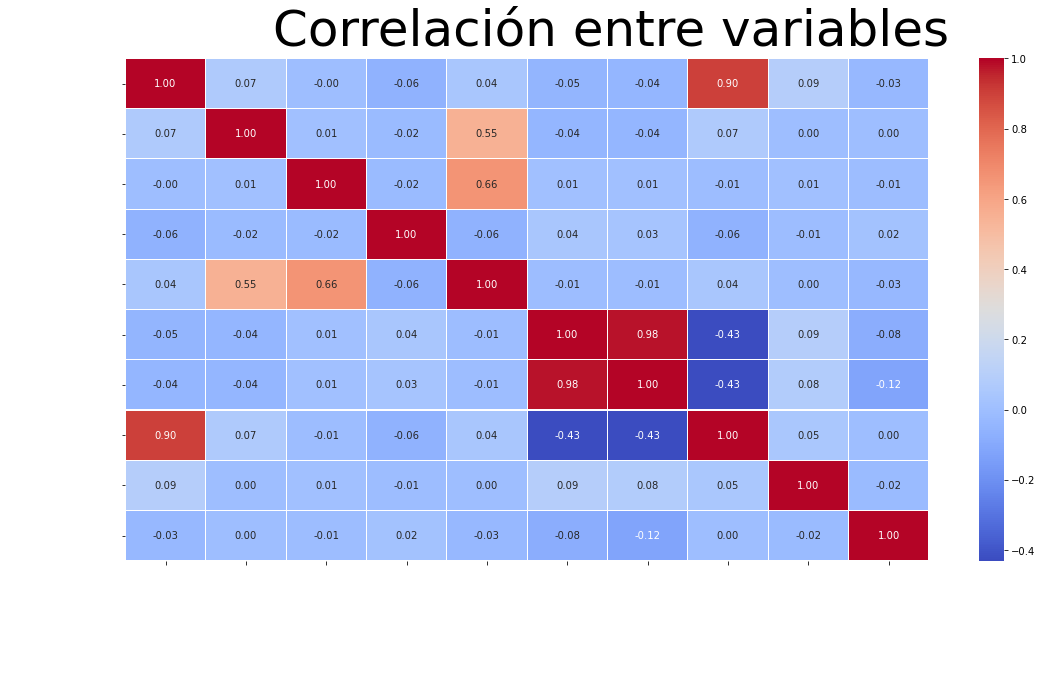

In [7]:
f, ax = plt.subplots(figsize=(18, 9))
corr = df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.9)
plt.xticks(color='white')
plt.yticks(color='white')

t= f.suptitle('Correlación entre variables', fontsize=50)

### Transformacion de Variables


In [8]:
a = df['PRODUCT_LINE'].str.split(',')

b = []
for i in range(2823):
    
    a0 = a[i]
    
    b.append(a0[0])
    
b

#una lista con todos los tipos de "vehiculos"

['Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Classic Cars',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycles',
 'Motorcycle

In [9]:
data = pd.DataFrame({'q': b})
data['q'] = data['q'].astype('category')
data['q'] = data['q'].cat.reorder_categories(set(b), ordered=True)
data['q'] = data['q'].cat.codes
df['num_category'] = data['q']
df['num_category']
#categorizarlos por numero

0       4
1       4
2       4
3       4
4       4
       ..
2818    2
2819    2
2820    2
2821    2
2822    2
Name: num_category, Length: 2823, dtype: int8

In [10]:

a = df['CUSTOMER_NAME'].str.split(',')

b = []
for i in range(2823):
    
    a0 = a[i]
    
    b.append(a0[0])

    #una lista con todos los tipos de "vendedores"
b 

['Land of Toys Inc.',
 'Reims Collectables',
 'Lyon Souveniers',
 'Toys4GrownUps.com',
 'Corporate Gift Ideas Co.',
 'Technics Stores Inc.',
 'Daedalus Designs Imports',
 'Herkku Gifts',
 'Mini Wheels Co.',
 'Auto Canal Petit',
 'Australian Collectors',
 'Vitachrome Inc.',
 'Tekni Collectables Inc.',
 'Gift Depot Inc.',
 'La Rochelle Gifts',
 "Marta's Replicas Co.",
 'Toys of Finland',
 'Baane Mini Imports',
 'Diecast Classics Inc.',
 'Land of Toys Inc.',
 'Salzburg Collectables',
 'Souveniers And Things Co.',
 'La Rochelle Gifts',
 'FunGiftIdeas.com',
 'UK Collectables',
 'Euro Shopping Channel',
 'Baane Mini Imports',
 'Volvo Model Replicas',
 'Corrida Auto Replicas',
 'Technics Stores Inc.',
 'Dragon Souveniers',
 'Classic Legends Inc.',
 'Australian Gift Network',
 'Classic Gift Ideas',
 'Saveley & Henriot',
 'Canadian Gift Exchange Network',
 'West Coast Collectables Co.',
 'Cambridge Collectables Co.',
 'Super Scale Inc.',
 'Tokyo Collectables',
 'Souveniers And Things Co.',
 'Am

In [11]:
data = pd.DataFrame({'q': b})
data['q'] = data['q'].astype('category')
data['q'] = data['q'].cat.reorder_categories(set(b), ordered=True)
data['q'] = data['q'].cat.codes
df['num_customer'] = data['q']
df['num_customer']

#categorizarlos por numero

0       10
1       77
2        4
3       59
4       81
        ..
2818    63
2819    67
2820    63
2821    84
2822    78
Name: num_customer, Length: 2823, dtype: int8

In [12]:
a = df['PRODUCT_CODE'].str.split(',')
b = []
for i in range(2823):
    
    a0 = a[i]
    
    b.append(a0[0])
    
data = pd.DataFrame({'q': b})
data['q'] = data['q'].astype('category')
data['q'] = data['q'].cat.reorder_categories(set(b), ordered=True)
data['q'] = data['q'].cat.codes
df['num_PC'] = data['q']

In [13]:
df

,ORDER_NUMBER,QUANTITY_ORDERED,PRICE_EACH,ORDER_LINE_NUMBER,SALES,ORDER_DATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCT_LINE,PRODUCT_CODE,CUSTOMER_NAME,day_of_week,day,num_category,num_customer,num_PC
0,10107,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,S10_1678,Land of Toys Inc.,0,24,4,10,4
1,10121,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,S10_1678,Reims Collectables,2,7,4,77,4
2,10134,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,S10_1678,Lyon Souveniers,1,1,4,4,4
3,10145,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,S10_1678,Toys4GrownUps.com,0,25,4,59,4
4,10159,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,S10_1678,Corporate Gift Ideas Co.,4,10,4,81,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,10350,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,S72_3212,Euro Shopping Channel,3,2,2,63,36
2819,10373,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,S72_3212,"Oulu Toy Supplies, Inc.",0,31,2,67,36
2820,10386,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,S72_3212,Euro Shopping Channel,1,1,2,63,36
2821,10397,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,S72_3212,Alpha Cognac,0,28,2,84,36


In [14]:
#valores nulos
missing_percentages = (df.isnull().sum() / len(df)) * 100
print(missing_percentages)

ORDER_NUMBER         0.0
QUANTITY_ORDERED     0.0
PRICE_EACH           0.0
ORDER_LINE_NUMBER    0.0
SALES                0.0
ORDER_DATE           0.0
QTR_ID               0.0
MONTH_ID             0.0
YEAR_ID              0.0
PRODUCT_LINE         0.0
PRODUCT_CODE         0.0
CUSTOMER_NAME        0.0
day_of_week          0.0
day                  0.0
num_category         0.0
num_customer         0.0
num_PC               0.0
dtype: float64


In [15]:
b = df.groupby(['num_category', 'num_PC', 'PRODUCT_LINE']).agg({'SALES': 'sum', 'QUANTITY_ORDERED': 'sum'})
b = b.reset_index()
idx = b.groupby('num_category')['QUANTITY_ORDERED'].transform(max) == b['QUANTITY_ORDERED']
most_sold_products = b[idx]
table = most_sold_products[['PRODUCT_LINE', 'num_category', 'num_PC', 'SALES', 'QUANTITY_ORDERED']]
table.columns = ['Nombre categoria', 'Categoría', 'Producto más vendido', 'Ventas', 'Cantidad vendida']

#  producto más vendido por 'num_category'
table

,Nombre categoria,Categoría,Producto más vendido,Ventas,Cantidad vendida
20,Vintage Cars,0,96,50217.95,999
59,Classic Cars,1,103,288245.42,1774
63,Ships,2,52,74111.76,990
79,Trucks and Buses,3,79,123723.08,1031
82,Motorcycles,4,6,140006.16,964
94,Planes,5,1,76175.63,1029
106,Trains,6,21,71495.78,945


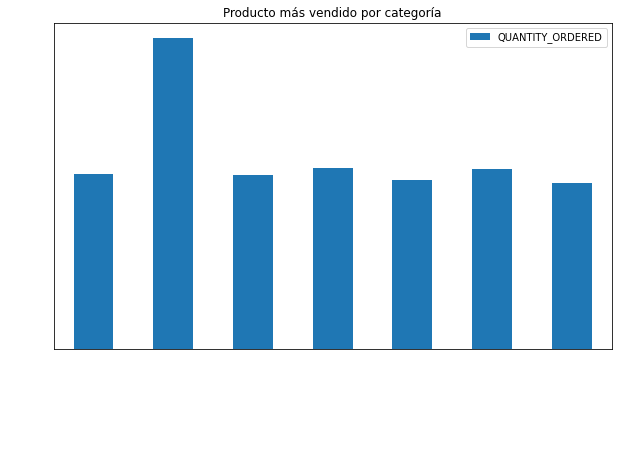

In [16]:
most_sold_products = b[idx]

fig, ax = plt.subplots(figsize=(10, 6))
most_sold_products.plot(x='PRODUCT_LINE', y='QUANTITY_ORDERED', kind='bar', ax=ax)

ax.set_xlabel('Categoría')
ax.set_ylabel('Cantidad vendida')
ax.set_title('Producto más vendido por categoría')

#se usa debido al uso del modo oscuro del navegador, si las letras se ven blancas y el navegador se muestra
#en modo claro, comente las siguientes lineas de codigo
ax.set_xlabel(ax.get_xlabel(), color='white')
ax.set_ylabel(ax.get_ylabel(), color='white')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
#hasta aqui

plt.show()

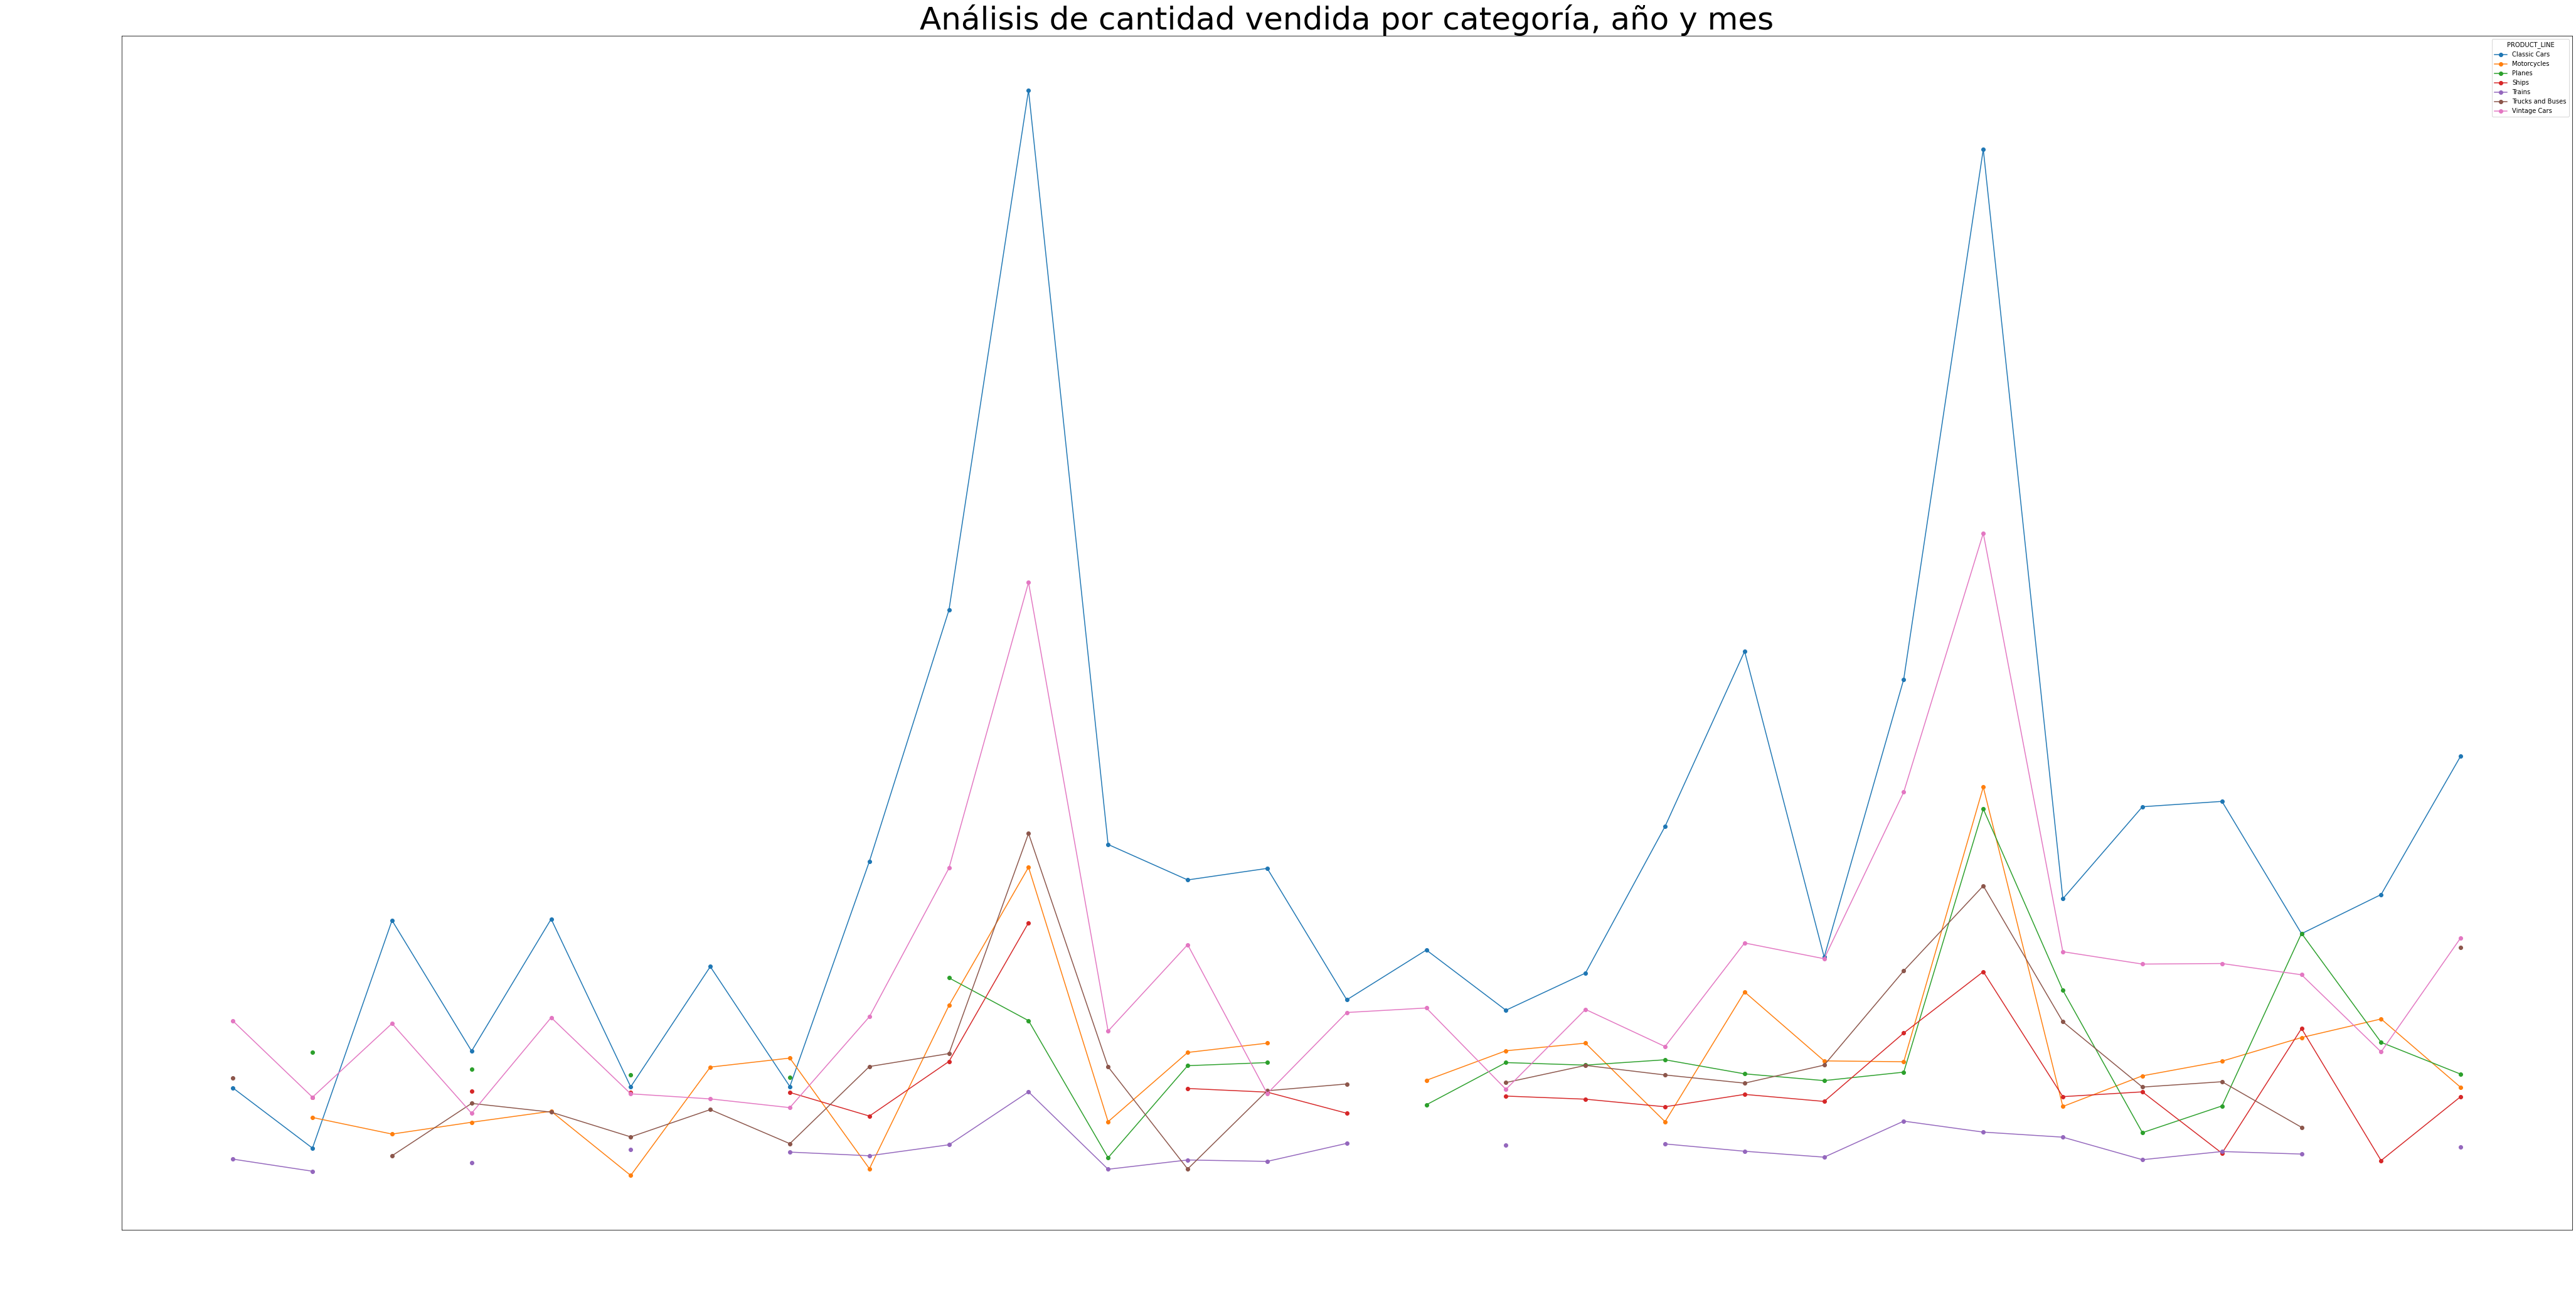

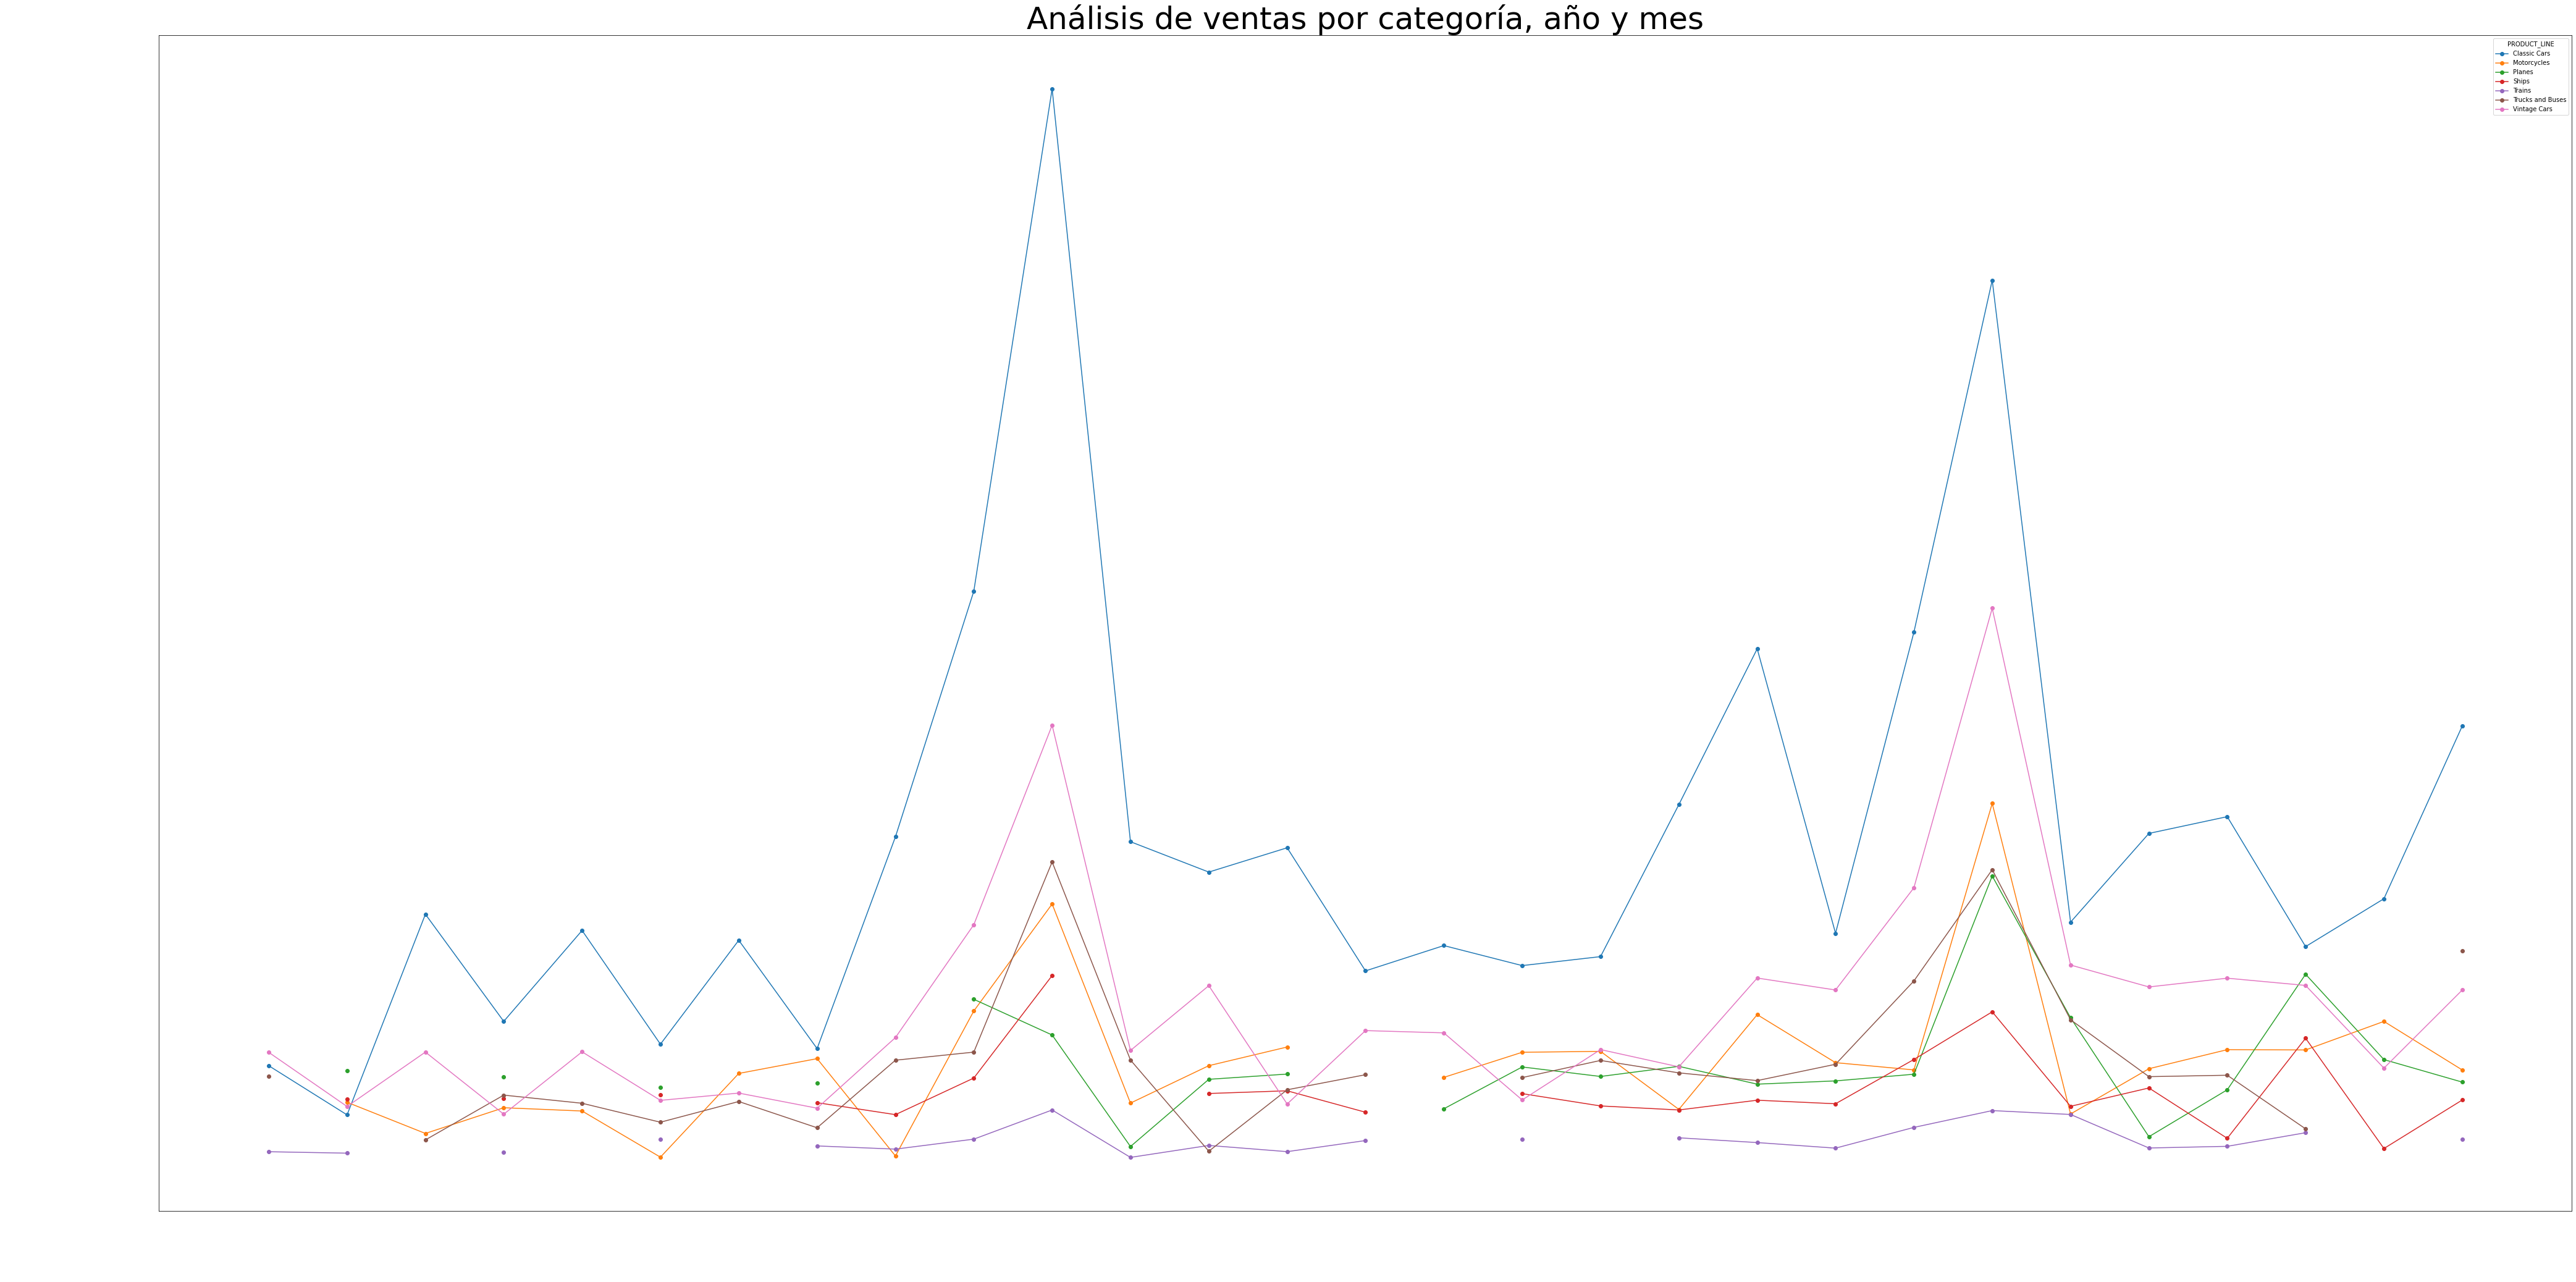

In [17]:
c = df.groupby(['YEAR_ID','MONTH_ID','PRODUCT_LINE']).agg({'QUANTITY_ORDERED': 'sum', 'SALES': 'sum'})
c = c.reset_index()


fig, ax1 = plt.subplots(figsize=(70, 35))
c.groupby(['YEAR_ID','MONTH_ID', 'PRODUCT_LINE'])['QUANTITY_ORDERED'].sum().unstack().plot(kind='line', ax=ax1, marker='o', fontsize=50)
ax1.set_xlabel('Año y Mes', fontsize=50)
ax1.set_ylabel('Cantidad vendida', fontsize=50)
ax1.set_title('Análisis de cantidad vendida por categoría, año y mes', fontsize=50)


fig, ax2 = plt.subplots(figsize=(70, 35))
c.groupby(['YEAR_ID','MONTH_ID','PRODUCT_LINE'])['SALES'].sum().unstack().plot(kind='line', ax=ax2, marker='o', fontsize=50)
ax2.set_xlabel('Año y Mes', fontsize=50)
ax2.set_ylabel('Ventas', fontsize=50)
ax2.set_title('Análisis de ventas por categoría, año y mes', fontsize=50)

#se usa debido al uso del modo oscuro del navegador, si las letras se ven blancas y el navegador se muestra
#en modo claro, comente las siguientes lineas de codigo
ax1.set_xlabel(ax1.get_xlabel(), color='white')
ax1.set_ylabel(ax1.get_ylabel(), color='white')


ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')


ax2.set_xlabel(ax2.get_xlabel(), color='white', fontsize=50)
ax2.set_ylabel(ax2.get_ylabel(), color='white', fontsize=50)


ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')
#hasta aqui


plt.show()

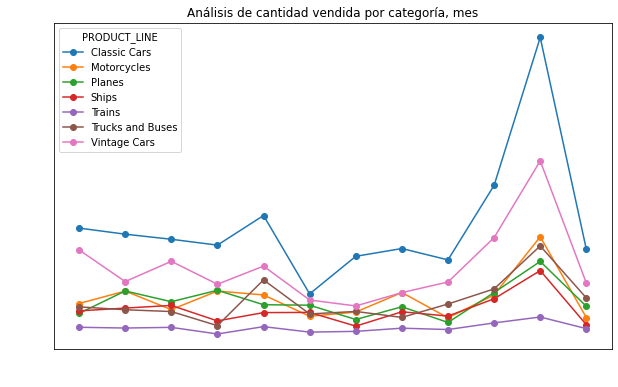

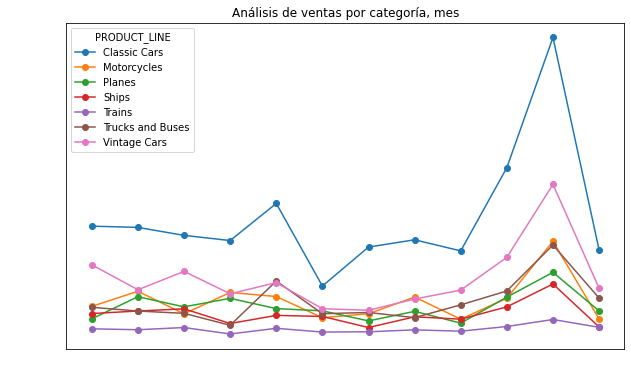

In [18]:
d = df.groupby(['MONTH_ID','PRODUCT_LINE']).agg({'QUANTITY_ORDERED': 'sum', 'SALES': 'sum'})
d = d.reset_index()

# Crear el primer gráfico para la cantidad vendida
fig, ax1 = plt.subplots(figsize=(10, 6))
d.groupby(['MONTH_ID', 'PRODUCT_LINE'])['QUANTITY_ORDERED'].sum().unstack().plot(kind='line', ax=ax1, marker='o')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Cantidad vendida')
ax1.set_title('Análisis de cantidad vendida por categoría, mes')

# Crear el segundo gráfico para las ventas
fig, ax2 = plt.subplots(figsize=(10, 6))
d.groupby(['MONTH_ID','PRODUCT_LINE'])['SALES'].sum().unstack().plot(kind='line', ax=ax2, marker='o')
ax2.set_xlabel('Mes')
ax2.set_ylabel('Ventas')
ax2.set_title('Análisis de ventas por categoría, mes')


#se usa debido al uso del modo oscuro del navegador, si las letras se ven blancas y el navegador se muestra
#en modo claro, comente las siguientes lineas de codigo
ax1.set_xlabel(ax1.get_xlabel(), color='white')
ax1.set_ylabel(ax1.get_ylabel(), color='white')


ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')


ax2.set_xlabel(ax2.get_xlabel(), color='white')
ax2.set_ylabel(ax2.get_ylabel(), color='white')


ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')
#hasta aqui

plt.show()

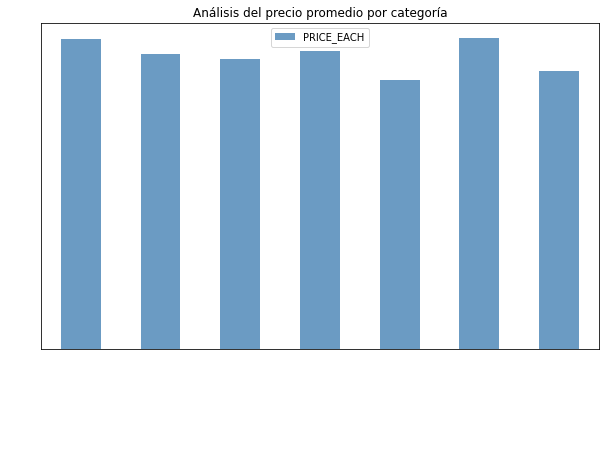

In [19]:
# Agrupar los datos
e = df.groupby(['PRODUCT_LINE']).agg({'PRICE_EACH': 'mean'})


e = e.reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
e.plot(x='PRODUCT_LINE', y='PRICE_EACH', kind='bar', ax=ax, color='steelblue', alpha=0.8)
ax.set_xlabel('Categoría')
ax.set_ylabel('Precio promedio')
ax.set_title('Análisis del precio promedio por categoría')

#se usa debido al uso del modo oscuro del navegador, si las letras se ven blancas y el navegador se muestra
#en modo claro, comente las siguientes lineas de codigo
ax.set_xlabel(ax.get_xlabel(), color='white')
ax.set_ylabel(ax.get_ylabel(), color='white')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
#hasta aqui

plt.show()

In [20]:
unique_values = df[['PRODUCT_LINE', 'num_category']].drop_duplicates().sort_values('num_category')
unique_values

,PRODUCT_LINE,num_category
475,Vintage Cars,0
26,Classic Cars,1
935,Ships,2
212,Trucks and Buses,3
0,Motorcycles,4
552,Planes,5
1065,Trains,6


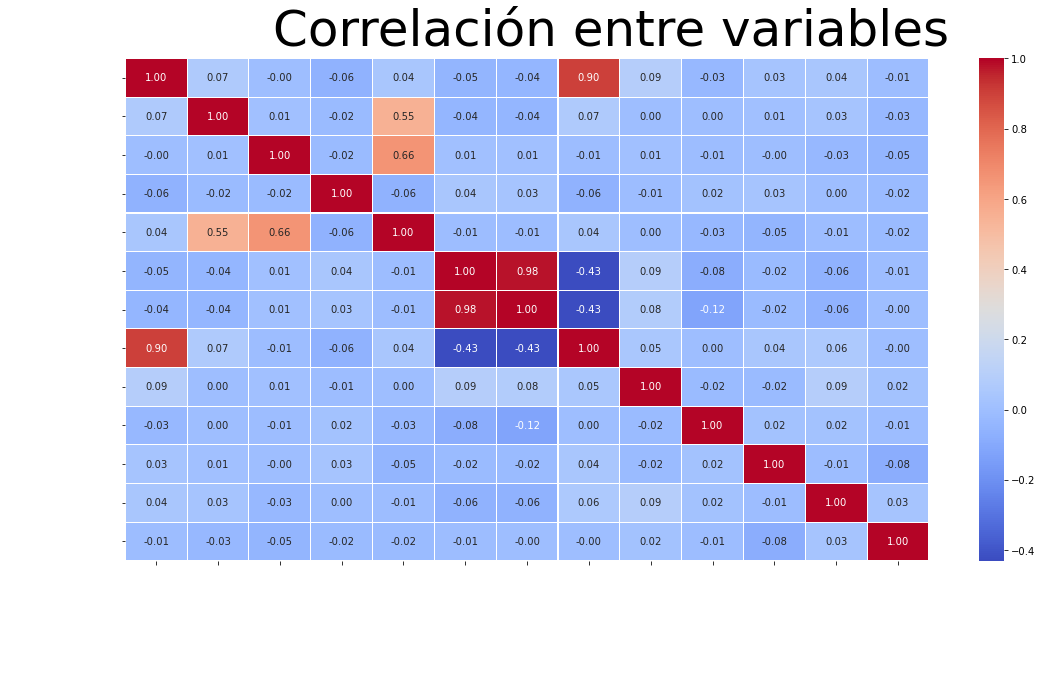

In [21]:
f, ax = plt.subplots(figsize=(18, 9))
corr = df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.9)
plt.xticks(color='white')
plt.yticks(color='white')

t= f.suptitle('Correlación entre variables', fontsize=50)

# Modelo Univariable

In [22]:
df.set_index('ORDER_DATE', inplace=True)

In [23]:
df

,ORDER_NUMBER,QUANTITY_ORDERED,PRICE_EACH,ORDER_LINE_NUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,PRODUCT_LINE,PRODUCT_CODE,CUSTOMER_NAME,day_of_week,day,num_category,num_customer,num_PC
ORDER_DATE,,,,,,,,,,,,,,,,
2003-02-24,10107,30,95.70,2,2871.00,1,2,2003,Motorcycles,S10_1678,Land of Toys Inc.,0,24,4,10,4
2003-05-07,10121,34,81.35,5,2765.90,2,5,2003,Motorcycles,S10_1678,Reims Collectables,2,7,4,77,4
2003-07-01,10134,41,94.74,2,3884.34,3,7,2003,Motorcycles,S10_1678,Lyon Souveniers,1,1,4,4,4
2003-08-25,10145,45,83.26,6,3746.70,3,8,2003,Motorcycles,S10_1678,Toys4GrownUps.com,0,25,4,59,4
2003-10-10,10159,49,100.00,14,5205.27,4,10,2003,Motorcycles,S10_1678,Corporate Gift Ideas Co.,4,10,4,81,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-12-02,10350,20,100.00,15,2244.40,4,12,2004,Ships,S72_3212,Euro Shopping Channel,3,2,2,63,36
2005-01-31,10373,29,100.00,1,3978.51,1,1,2005,Ships,S72_3212,"Oulu Toy Supplies, Inc.",0,31,2,67,36
2005-03-01,10386,43,100.00,4,5417.57,1,3,2005,Ships,S72_3212,Euro Shopping Channel,1,1,2,63,36


In [24]:
from sklearn.preprocessing import MinMaxScaler
X = df['SALES']
PASOS = 365

# Convertir series en aprendizaje supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # Secuencia de entrada (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # Secuencia de pronóstico (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # Unir todo
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Eliminar filas con valores NaN
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

# Cargar conjunto de datos
values = X.values

# Asegurarse de que todos los datos sean de tipo float
values = values.astype('float32')

# Normalizar características
scaler = MinMaxScaler(feature_range=(-1, 1))
values = values.reshape(-1, 1) # Esto se hace porque tenemos solo 1 dimensión
scaled = scaler.fit_transform(values)

# Convertir en aprendizaje supervisado
reframed = series_to_supervised(scaled, PASOS, 1)
reframed



,var1(t-365),var1(t-364),var1(t-363),var1(t-362),var1(t-361),var1(t-360),var1(t-359),var1(t-358),var1(t-357),var1(t-356),var1(t-355),var1(t-354),var1(t-353),var1(t-352),var1(t-351),var1(t-350),var1(t-349),var1(t-348),var1(t-347),var1(t-346),var1(t-345),var1(t-344),var1(t-343),var1(t-342),var1(t-341),var1(t-340),var1(t-339),var1(t-338),var1(t-337),var1(t-336),var1(t-335),var1(t-334),var1(t-333),var1(t-332),var1(t-331),var1(t-330),var1(t-329),var1(t-328),var1(t-327),var1(t-326),var1(t-325),var1(t-324),var1(t-323),var1(t-322),var1(t-321),var1(t-320),var1(t-319),var1(t-318),var1(t-317),var1(t-316),var1(t-315),var1(t-314),var1(t-313),var1(t-312),var1(t-311),var1(t-310),var1(t-309),var1(t-308),var1(t-307),var1(t-306),var1(t-305),var1(t-304),var1(t-303),var1(t-302),var1(t-301),var1(t-300),var1(t-299),var1(t-298),var1(t-297),var1(t-296),var1(t-295),var1(t-294),var1(t-293),var1(t-292),var1(t-291),var1(t-290),var1(t-289),var1(t-288),var1(t-287),var1(t-286),var1(t-285),var1(t-284),var1(t-283),var1(t-282),var1(t-281),var1(t-280),var1(t-279),var1(t-278),var1(t-277),var1(t-276),var1(t-275),var1(t-274),var1(t-273),var1(t-272),var1(t-271),var1(t-270),var1(t-269),var1(t-268),var1(t-267),var1(t-266),var1(t-265),var1(t-264),var1(t-263),var1(t-262),var1(t-261),var1(t-260),var1(t-259),var1(t-258),var1(t-257),var1(t-256),var1(t-255),var1(t-254),var1(t-253),var1(t-252),var1(t-251),var1(t-250),var1(t-249),var1(t-248),var1(t-247),var1(t-246),var1(t-245),var1(t-244),var1(t-243),var1(t-242),var1(t-241),var1(t-240),var1(t-239),var1(t-238),var1(t-237),var1(t-236),var1(t-235),var1(t-234),var1(t-233),var1(t-232),var1(t-231),var1(t-230),var1(t-229),var1(t-228),var1(t-227),var1(t-226),var1(t-225),var1(t-224),var1(t-223),var1(t-222),var1(t-221),var1(t-220),var1(t-219),var1(t-218),var1(t-217),var1(t-216),var1(t-215),var1(t-214),var1(t-213),var1(t-212),var1(t-211),var1(t-210),var1(t-209),var1(t-208),var1(t-207),var1(t-206),var1(t-205),var1(t-204),var1(t-203),var1(t-202),var1(t-201),var1(t-200),var1(t-199),var1(t-198),var1(t-197),var1(t-196),var1(t-195),var1(t-194),var1(t-193),var1(t-192),var1(t-191),var1(t-190),var1(t-189),var1(t-188),var1(t-187),var1(t-186),var1(t-185),var1(t-184),var1(t-183),var1(t-182),var1(t-181),var1(t-180),var1(t-179),var1(t-178),var1(t-177),var1(t-176),var1(t-175),var1(t-174),var1(t-173),var1(t-172),var1(t-171),var1(t-170),var1(t-169),var1(t-168),var1(t-167),var1(t-166),var1(t-165),var1(t-164),var1(t-163),var1(t-162),var1(t-161),var1(t-160),var1(t-159),var1(t-158),var1(t-157),var1(t-156),var1(t-155),var1(t-154),var1(t-153),var1(t-152),var1(t-151),var1(t-150),var1(t-149),var1(t-148),var1(t-147),var1(t-146),var1(t-145),var1(t-144),var1(t-143),var1(t-142),var1(t-141),var1(t-140),var1(t-139),var1(t-138),var1(t-137),var1(t-136),var1(t-135),var1(t-134),var1(t-133),var1(t-132),var1(t-131),var1(t-130),var1(t-129),var1(t-128),var1(t-127),var1(t-126),var1(t-125),var1(t-124),var1(t-123),var1(t-122),var1(t-121),var1(t-120),var1(t-119),var1(t-118),var1(t-117),var1(t-116),var1(t-115),var1(t-114),var1(t-113),var1(t-112),var1(t-111),var1(t-110),var1(t-109),var1(t-108),var1(t-107),var1(t-106),var1(t-105),var1(t-104),var1(t-103),var1(t-102),var1(t-101),var1(t-100),var1(t-99),var1(t-98),var1(t-97),var1(t-96),var1(t-95),var1(t-94),var1(t-93),var1(t-92),var1(t-91),var1(t-90),var1(t-89),var1(t-88),var1(t-87),var1(t-86),var1(t-85),var1(t-84),var1(t-83),var1(t-82),var1(t-81),var1(t-80),var1(t-79),var1(t-78),var1(t-77),var1(t-76),var1(t-75),var1(t-74),var1(t-73),var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),var1(t-62),var1(t-61),var1(t-60),var1(t-59),var1(t-58),var1(t-57),var1(t-56),var1(t-55),var1(t-54),var1(t-53),var1(t-52),var1(t-51),var1(t-50),var1(t-49),var1(t-48),var1(t-47),var1(t-46),var1(t-45),var1(t-44),var1(t-43),var1(t-42),var1(t-41),var1(t-40),var1(t-39),var1(t-38),var1(t-37),var1(t-36),var1(t-35),var1(t-34),var1(t-33),var1(t-32),var1(t-31),var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1

In [25]:
# Obtener el número total de meses en el dataframe agrupado
values = reframed.values
total_months = len(reframed)

# Restar 1 al número total de meses para obtener el número de meses para el conjunto de entrenamiento
train_months = total_months - (PASOS)

# Calcular n_train_days en base a los meses
days_per_month = 30.44  # Promedio de días en un mes
total_days = 28  # Reemplaza con el número total de días en tu dataframe agrupado
n_train_days = train_months

# Dividir en conjuntos de entrenamiento y prueba
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# Dividir en entradas y salidas
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]

# Reorganizar la entrada en 3D [muestras, pasos de tiempo, características]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(2093, 1, 365) (2093,) (365, 1, 365) (365,)


In [26]:
print( len(reframed) )

2458


In [27]:

def crear_modeloFF():
    model = Sequential() 

    # Capa de entrada
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, PASOS)))
    
    # Capas ocultas
    # Añadimos algunas capas LSTM adicionales con dropout para evitar el sobreajuste
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    
    # Añadimos una capa densa final antes de la capa de salida
    model.add(Dense(500, activation='relu'))
    
    # Capa de salida
    model.add(Dense(1))
    
    model.compile(loss='mean_absolute_error', optimizer='Adam', metrics=["mse"])
    
    model.summary()
    return model


In [28]:

EPOCHS=500

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 50)             83200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               25500     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

2093/2093 [==============================] - 0s 18us/step - loss: 0.1566 - mse: 0.0472 - val_loss: 0.1291 - val_mse: 0.0301
Epoch 52/500
2093/2093 [==============================] - 0s 18us/step - loss: 0.1525 - mse: 0.0457 - val_loss: 0.1302 - val_mse: 0.0320
Epoch 53/500
2093/2093 [==============================] - 0s 18us/step - loss: 0.1528 - mse: 0.0461 - val_loss: 0.1266 - val_mse: 0.0330
Epoch 54/500
2093/2093 [==============================] - 0s 18us/step - loss: 0.1583 - mse: 0.0480 - val_loss: 0.1251 - val_mse: 0.0326
Epoch 55/500
2093/2093 [==============================] - 0s 18us/step - loss: 0.1572 - mse: 0.0476 - val_loss: 0.1250 - val_mse: 0.0318
Epoch 56/500
2093/2093 [==============================] - 0s 18us/step - loss: 0.1549 - mse: 0.0476 - val_loss: 0.1356 - val_mse: 0.0320
Epoch 57/500
2093/2093 [==============================] - 0s 18us/step - loss: 0.1558 - mse: 0.0472 - val_loss: 0.1398 - val_mse: 0.0321
Epoch 58/500
2093/2093 [==============================

Epoch 111/500
2093/2093 [==============================] - 0s 17us/step - loss: 0.1193 - mse: 0.0325 - val_loss: 0.1443 - val_mse: 0.0362
Epoch 112/500
2093/2093 [==============================] - 0s 17us/step - loss: 0.1194 - mse: 0.0330 - val_loss: 0.1353 - val_mse: 0.0348
Epoch 113/500
2093/2093 [==============================] - 0s 19us/step - loss: 0.1212 - mse: 0.0345 - val_loss: 0.1449 - val_mse: 0.0356
Epoch 114/500
2093/2093 [==============================] - 0s 17us/step - loss: 0.1226 - mse: 0.0336 - val_loss: 0.1423 - val_mse: 0.0355
Epoch 115/500
2093/2093 [==============================] - 0s 17us/step - loss: 0.1226 - mse: 0.0339 - val_loss: 0.1375 - val_mse: 0.0354
Epoch 116/500
2093/2093 [==============================] - 0s 17us/step - loss: 0.1238 - mse: 0.0344 - val_loss: 0.1432 - val_mse: 0.0345
Epoch 117/500
2093/2093 [==============================] - 0s 17us/step - loss: 0.1203 - mse: 0.0326 - val_loss: 0.1383 - val_mse: 0.0362
Epoch 118/500
2093/2093 [=========

2093/2093 [==============================] - 0s 19us/step - loss: 0.1031 - mse: 0.0266 - val_loss: 0.1440 - val_mse: 0.0385
Epoch 171/500
2093/2093 [==============================] - 0s 19us/step - loss: 0.0991 - mse: 0.0249 - val_loss: 0.1493 - val_mse: 0.0382
Epoch 172/500
2093/2093 [==============================] - 0s 18us/step - loss: 0.0983 - mse: 0.0250 - val_loss: 0.1538 - val_mse: 0.0418
Epoch 173/500
2093/2093 [==============================] - 0s 18us/step - loss: 0.1014 - mse: 0.0251 - val_loss: 0.1541 - val_mse: 0.0409
Epoch 174/500
2093/2093 [==============================] - 0s 19us/step - loss: 0.0984 - mse: 0.0253 - val_loss: 0.1407 - val_mse: 0.0372
Epoch 175/500
2093/2093 [==============================] - 0s 17us/step - loss: 0.0987 - mse: 0.0247 - val_loss: 0.1474 - val_mse: 0.0368
Epoch 176/500
2093/2093 [==============================] - 0s 17us/step - loss: 0.0986 - mse: 0.0242 - val_loss: 0.1442 - val_mse: 0.0374
Epoch 177/500
2093/2093 [=======================

2093/2093 [==============================] - 0s 21us/step - loss: 0.0840 - mse: 0.0201 - val_loss: 0.1560 - val_mse: 0.0451
Epoch 230/500
2093/2093 [==============================] - 0s 21us/step - loss: 0.0859 - mse: 0.0208 - val_loss: 0.1572 - val_mse: 0.0427
Epoch 231/500
2093/2093 [==============================] - 0s 20us/step - loss: 0.0860 - mse: 0.0203 - val_loss: 0.1507 - val_mse: 0.0394
Epoch 232/500
2093/2093 [==============================] - 0s 20us/step - loss: 0.0850 - mse: 0.0200 - val_loss: 0.1465 - val_mse: 0.0380
Epoch 233/500
2093/2093 [==============================] - 0s 20us/step - loss: 0.0829 - mse: 0.0193 - val_loss: 0.1568 - val_mse: 0.0411
Epoch 234/500
2093/2093 [==============================] - 0s 21us/step - loss: 0.0841 - mse: 0.0191 - val_loss: 0.1466 - val_mse: 0.0373
Epoch 235/500
2093/2093 [==============================] - 0s 21us/step - loss: 0.0810 - mse: 0.0190 - val_loss: 0.1528 - val_mse: 0.0396
Epoch 236/500
2093/2093 [=======================

2093/2093 [==============================] - 0s 19us/step - loss: 0.0735 - mse: 0.0164 - val_loss: 0.1509 - val_mse: 0.0385
Epoch 289/500
2093/2093 [==============================] - 0s 21us/step - loss: 0.0747 - mse: 0.0166 - val_loss: 0.1475 - val_mse: 0.0393
Epoch 290/500
2093/2093 [==============================] - 0s 22us/step - loss: 0.0733 - mse: 0.0162 - val_loss: 0.1532 - val_mse: 0.0399
Epoch 291/500
2093/2093 [==============================] - 0s 20us/step - loss: 0.0719 - mse: 0.0163 - val_loss: 0.1513 - val_mse: 0.0407
Epoch 292/500
2093/2093 [==============================] - 0s 20us/step - loss: 0.0718 - mse: 0.0161 - val_loss: 0.1536 - val_mse: 0.0397
Epoch 293/500
2093/2093 [==============================] - 0s 19us/step - loss: 0.0729 - mse: 0.0160 - val_loss: 0.1515 - val_mse: 0.0403
Epoch 294/500
2093/2093 [==============================] - 0s 19us/step - loss: 0.0727 - mse: 0.0157 - val_loss: 0.1514 - val_mse: 0.0395
Epoch 295/500
2093/2093 [=======================

2093/2093 [==============================] - 0s 18us/step - loss: 0.0664 - mse: 0.0142 - val_loss: 0.1520 - val_mse: 0.0420
Epoch 348/500
2093/2093 [==============================] - 0s 17us/step - loss: 0.0654 - mse: 0.0139 - val_loss: 0.1523 - val_mse: 0.0421
Epoch 349/500
2093/2093 [==============================] - 0s 18us/step - loss: 0.0635 - mse: 0.0135 - val_loss: 0.1606 - val_mse: 0.0441
Epoch 350/500
2093/2093 [==============================] - 0s 17us/step - loss: 0.0697 - mse: 0.0147 - val_loss: 0.1495 - val_mse: 0.0419
Epoch 351/500
2093/2093 [==============================] - 0s 18us/step - loss: 0.0685 - mse: 0.0144 - val_loss: 0.1579 - val_mse: 0.0429
Epoch 352/500
2093/2093 [==============================] - 0s 20us/step - loss: 0.0697 - mse: 0.0145 - val_loss: 0.1521 - val_mse: 0.0423
Epoch 353/500
2093/2093 [==============================] - 0s 18us/step - loss: 0.0700 - mse: 0.0144 - val_loss: 0.1606 - val_mse: 0.0447
Epoch 354/500
2093/2093 [=======================

2093/2093 [==============================] - 0s 17us/step - loss: 0.0606 - mse: 0.0123 - val_loss: 0.1524 - val_mse: 0.0416
Epoch 407/500
2093/2093 [==============================] - 0s 19us/step - loss: 0.0605 - mse: 0.0123 - val_loss: 0.1599 - val_mse: 0.0437
Epoch 408/500
2093/2093 [==============================] - 0s 19us/step - loss: 0.0606 - mse: 0.0129 - val_loss: 0.1515 - val_mse: 0.0410
Epoch 409/500
2093/2093 [==============================] - 0s 19us/step - loss: 0.0618 - mse: 0.0127 - val_loss: 0.1596 - val_mse: 0.0416
Epoch 410/500
2093/2093 [==============================] - 0s 22us/step - loss: 0.0637 - mse: 0.0128 - val_loss: 0.1565 - val_mse: 0.0426
Epoch 411/500
2093/2093 [==============================] - 0s 18us/step - loss: 0.0614 - mse: 0.0124 - val_loss: 0.1614 - val_mse: 0.0440
Epoch 412/500
2093/2093 [==============================] - 0s 18us/step - loss: 0.0603 - mse: 0.0127 - val_loss: 0.1540 - val_mse: 0.0420
Epoch 413/500
2093/2093 [=======================

2093/2093 [==============================] - 0s 18us/step - loss: 0.0547 - mse: 0.0111 - val_loss: 0.1518 - val_mse: 0.0411
Epoch 466/500
2093/2093 [==============================] - 0s 17us/step - loss: 0.0550 - mse: 0.0113 - val_loss: 0.1494 - val_mse: 0.0391
Epoch 467/500
2093/2093 [==============================] - 0s 17us/step - loss: 0.0564 - mse: 0.0110 - val_loss: 0.1554 - val_mse: 0.0418
Epoch 468/500
2093/2093 [==============================] - 0s 17us/step - loss: 0.0550 - mse: 0.0106 - val_loss: 0.1532 - val_mse: 0.0409
Epoch 469/500
2093/2093 [==============================] - 0s 17us/step - loss: 0.0527 - mse: 0.0106 - val_loss: 0.1513 - val_mse: 0.0401
Epoch 470/500
2093/2093 [==============================] - 0s 18us/step - loss: 0.0555 - mse: 0.0108 - val_loss: 0.1514 - val_mse: 0.0404
Epoch 471/500
2093/2093 [==============================] - 0s 17us/step - loss: 0.0549 - mse: 0.0108 - val_loss: 0.1545 - val_mse: 0.0399
Epoch 472/500
2093/2093 [=======================

## Resultados

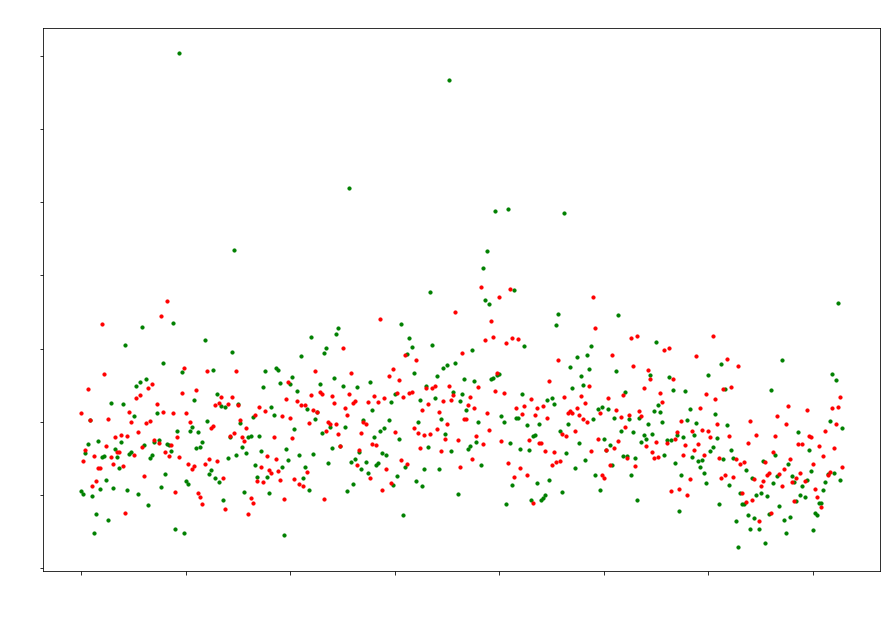

In [29]:
results=model.predict(x_val)

plt.figure(figsize=(15, 10))
plt.scatter(range(len(y_val)),y_val,c='g', s=10)
plt.scatter(range(len(results)),results,c='r', s=10)
plt.title('validate', color='white', fontsize=20)
plt.xlabel('Num', color='white', fontsize=15)
plt.ylabel('', color='white', fontsize=15)
plt.xticks(rotation=45, color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)
plt.show()

In [30]:
loss, accuracy = model.evaluate(x_val, y_val)
print('Precisión en el conjunto de prueba:', accuracy)

365/365 [==============================] - 0s 25us/step
Precisión en el conjunto de prueba: 0.040829095989465714


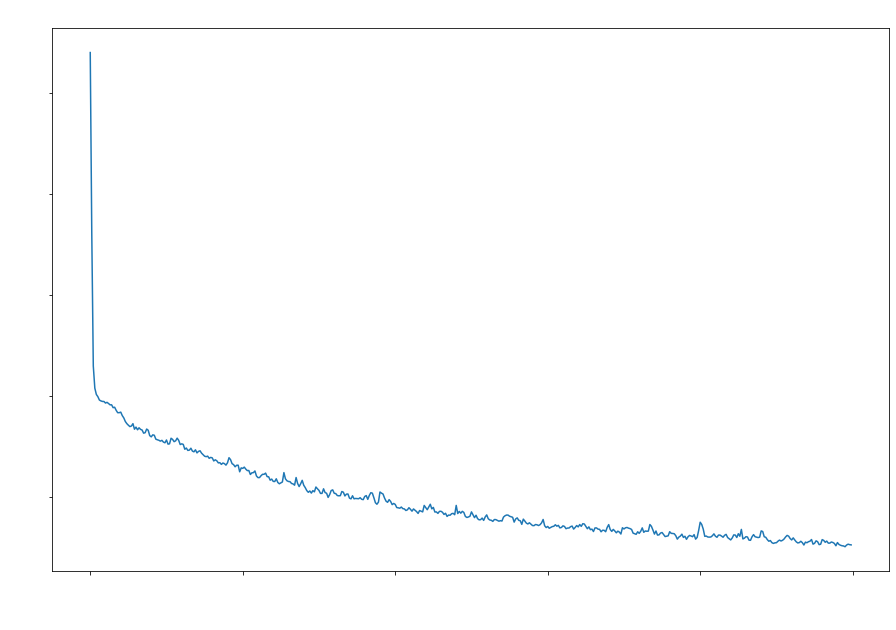

In [31]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'])
plt.title('loss', color='white', fontsize=20)
plt.xlabel('EPOCHS', color='white', fontsize=15)
plt.ylabel('%', color='white', fontsize=15)
plt.xticks(rotation=45, color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)
plt.show()

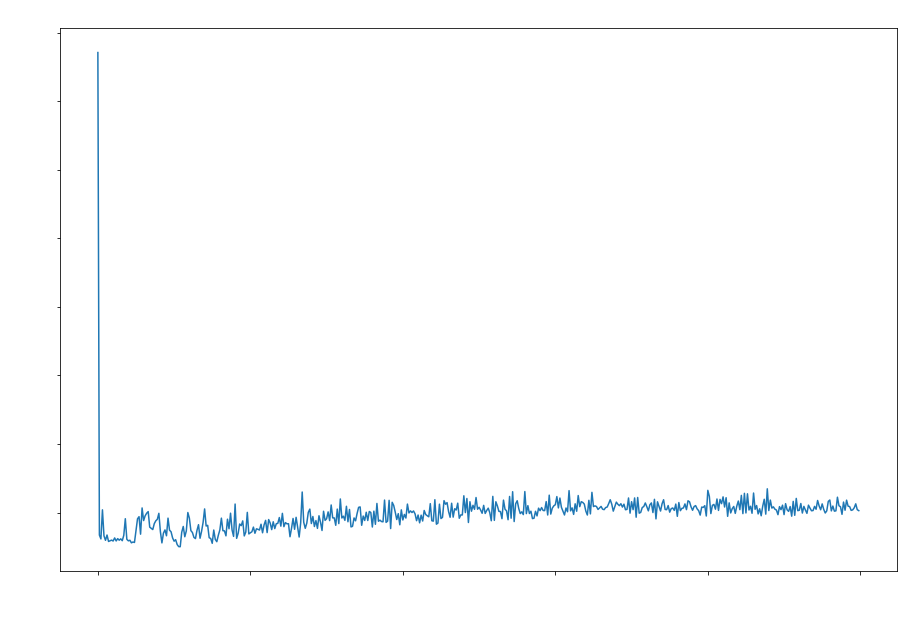

In [32]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['val_loss'])
plt.title('validate loss', color='white', fontsize=20)
plt.xlabel('EPOCHS', color='white', fontsize=15)
plt.ylabel('%', color='white', fontsize=15)
plt.xticks(rotation=45, color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)
plt.show()


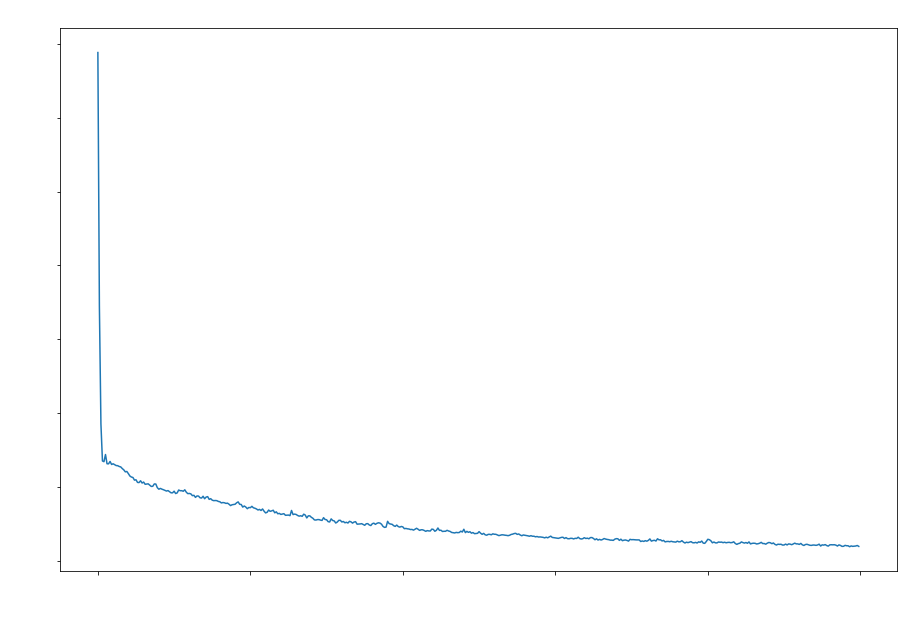

In [33]:
plt.figure(figsize=(15, 10))
plt.title('MSE', color='white', fontsize=20)
plt.plot(history.history['mse'])
plt.xlabel('EPOCHS', color='white', fontsize=15)
plt.ylabel('%', color='white', fontsize=15)
plt.xticks(rotation=45, color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)
plt.show()


In [34]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.round()

,real,prediccion,diferencia
0,1917.0,3354.0,-1437.0
1,1860.0,2473.0,-613.0
2,2624.0,2669.0,-45.0
3,2781.0,3814.0,-1033.0
4,3240.0,3232.0,7.0
...,...,...,...
360,2244.0,2710.0,-465.0
361,3979.0,3152.0,826.0
362,5418.0,3482.0,1936.0
363,2116.0,3665.0,-1549.0


In [35]:
compara2.describe().round()

,real,prediccion,diferencia
count,365.0,365.0,365.0
mean,3054.0,3097.0,-44.0
std,1204.0,818.0,1375.0
min,876.0,1361.0,-3354.0
25%,2231.0,2503.0,-934.0
50%,2864.0,3028.0,-180.0
75%,3718.0,3586.0,726.0
max,10067.0,5712.0,7520.0


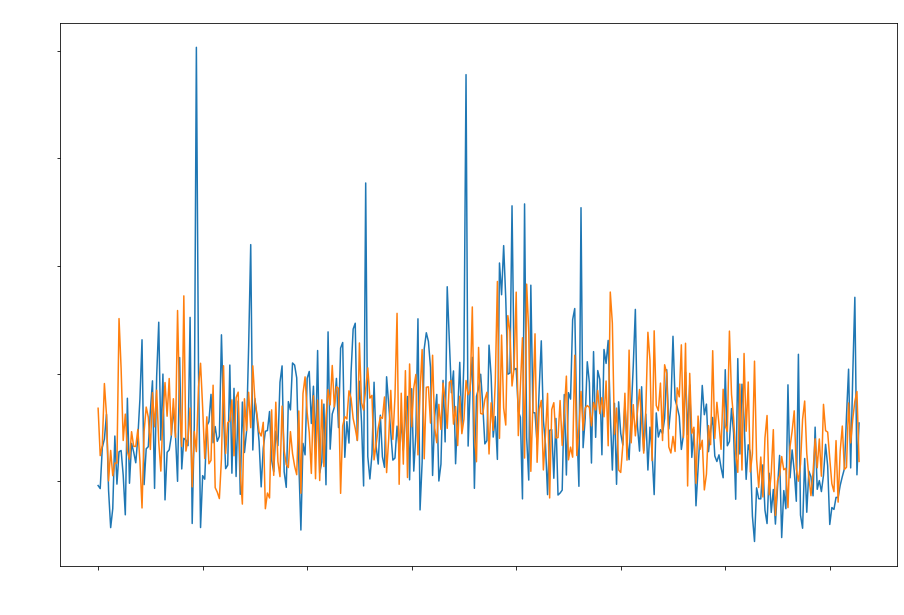

In [36]:
plt.figure(figsize=(15, 10))
compara2['real'].plot() #azul
compara2['prediccion'].plot() #rojo

plt.title('Predicciones Vs Real', color='white')
plt.xlabel('Mes', color='white')
plt.ylabel('Ventas', color='white')
plt.xticks(rotation=45, color='white')
plt.yticks(color='white')
plt.show()

## Nueva prediccion

In [37]:
def agregarNuevoValor(x_val,nuevoValor):
    for i in range(x_val.shape[2]-1):
        x_val[0][0][i] = x_val[0][0][i+1]
    x_val[0][0][x_val.shape[2]-1]=nuevoValor
    return x_val

results=[]
for i in range(365):
    parcial=model.predict(x_val)
    results.append(parcial[0])
    x_val=agregarNuevoValor(x_val,parcial[0])

In [38]:
adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)


In [39]:
prediccion = pd.DataFrame(inverted)
prediccion.round()

,0
0,3354.0
1,2885.0
2,2999.0
3,3725.0
4,3973.0
...,...
360,2781.0
361,3355.0
362,3252.0
363,2823.0


(array([1000., 2000., 3000., 4000., 5000., 6000., 7000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 1080x720 with 0 Axes>

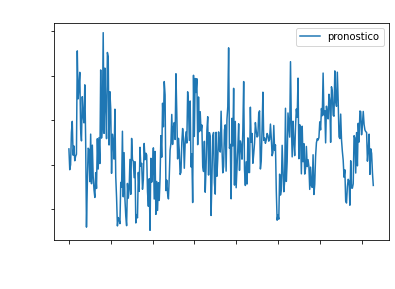

In [40]:
plt.figure(figsize=(15, 10))
prediccion = pd.DataFrame(inverted)
prediccion.columns = ['pronostico']
prediccion.plot()
prediccion.to_csv('pronostico.csv')
plt.title('Predicciones', color='white')
plt.xlabel('dia', color='white')
plt.ylabel('Ventas', color='white')
plt.xticks(rotation=45, color='white')
plt.yticks(color='white')


# Modelo Multivariable

In [41]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    print(agg.shape)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [42]:
df_modelo = df.drop(['PRODUCT_LINE', 'PRODUCT_CODE', 'CUSTOMER_NAME', 'MONTH_ID', 'YEAR_ID', 'day', 'ORDER_NUMBER', 'ORDER_LINE_NUMBER' ], axis=1)

In [43]:
df_modelo

,QUANTITY_ORDERED,PRICE_EACH,SALES,QTR_ID,day_of_week,num_category,num_customer,num_PC
ORDER_DATE,,,,,,,,
2003-02-24,30,95.70,2871.00,1,0,4,10,4
2003-05-07,34,81.35,2765.90,2,2,4,77,4
2003-07-01,41,94.74,3884.34,3,1,4,4,4
2003-08-25,45,83.26,3746.70,3,0,4,59,4
2003-10-10,49,100.00,5205.27,4,4,4,81,4
...,...,...,...,...,...,...,...,...
2004-12-02,20,100.00,2244.40,4,3,2,63,36
2005-01-31,29,100.00,3978.51,1,0,2,67,36
2005-03-01,43,100.00,5417.57,1,1,2,63,36


In [44]:
PASOS=12
X = df['SALES']
# load dataset
values = X.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

df_modelo['scaled'] = scaled
scaledMerge=df_modelo.drop('SALES',axis=1)
print(scaledMerge.shape)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed

(2823, 8)
(2823, 104)


,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var8(t-12),var1(t-11),var2(t-11),var3(t-11),var4(t-11),var5(t-11),var6(t-11),var7(t-11),var8(t-11),var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var8(t-10),var1(t-9),var2(t-9),var3(t-9),var4(t-9),var5(t-9),var6(t-9),var7(t-9),var8(t-9),var1(t-8),var2(t-8),var3(t-8),var4(t-8),var5(t-8),var6(t-8),var7(t-8),var8(t-8),var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
ORDER_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-05-18,30.0,95.70,1.0,0.0,4.0,10.0,4.0,-0.648713,34.0,81.35,2.0,2.0,4.0,77.0,4.0,-0.664168,41.0,94.74,3.0,1.0,4.0,4.0,4.0,-0.499700,45.0,83.26,3.0,0.0,4.0,59.0,4.0,-0.519940,49.0,100.00,4.0,4.0,4.0,81.0,4.0,-0.305455,36.0,96.66,4.0,1.0,4.0,61.0,4.0,-0.559194,29.0,86.13,4.0,1.0,4.0,87.0,4.0,-0.703597,48.0,100.00,4.0,1.0,4.0,73.0,4.0,-0.260303,22.0,98.57,4.0,0.0,4.0,0.0,4.0,-0.752011,41.0,100.00,1.0,3.0,4.0,48.0,4.0,-0.378514,37.0,100.00,1.0,4.0,4.0,44.0,4.0,-0.487741,23.0,100.00,2.0,0.0,4.0,79.0,4.0,-0.727809,28,100.00,2,1,4,76,4,-0.602003
2004-06-28,34.0,81.35,2.0,2.0,4.0,77.0,4.0,-0.664168,41.0,94.74,3.0,1.0,4.0,4.0,4.0,-0.499700,45.0,83.26,3.0,0.0,4.0,59.0,4.0,-0.519940,49.0,100.00,4.0,4.0,4.0,81.0,4.0,-0.305455,36.0,96.66,4.0,1.0,4.0,61.0,4.0,-0.559194,29.0,86.13,4.0,1.0,4.0,87.0,4.0,-0.703597,48.0,100.00,4.0,1.0,4.0,73.0,4.0,-0.260303,22.0,98.57,4.0,0.0,4.0,0.0,4.0,-0.752011,41.0,100.00,1.0,3.0,4.0,48.0,4.0,-0.378514,37.0,100.00,1.0,4.0,4.0,44.0,4.0,-0.487741,23.0,100.00,2.0,0.0,4.0,79.0,4.0,-0.727809,28.0,100.00,2.0,1.0,4.0,76.0,4.0,-0.602003,34,100.00,2,0,4,11,4,-0.530225
2004-07-23,41.0,94.74,3.0,1.0,4.0,4.0,4.0,-0.499700,45.0,83.26,3.0,0.0,4.0,59.0,4.0,-0.519940,49.0,100.00,4.0,4.0,4.0,81.0,4.0,-0.305455,36.0,96.66,4.0,1.0,4.0,61.0,4.0,-0.559194,29.0,86.13,4.0,1.0,4.0,87.0,4.0,-0.703597,48.0,100.00,4.0,1.0,4.0,73.0,4.0,-0.260303,22.0,98.57,4.0,0.0,4.0,0.0,4.0,-0.752011,41.0,100.00,1.0,3.0,4.0,48.0,4.0,-0.378514,37.0,100.00,1.0,4.0,4.0,44.0,4.0,-0.487741,23.0,100.00,2.0,0.0,4.0,79.0,4.0,-0.727809,28.0,100.00,2.0,1.0,4.0,76.0,4.0,-0.602003,34.0,100.00,2.0,0.0,4.0,11.0,4.0,-0.530225,45,92.83,3,4,4,41,4,-0.456612
2004-08-27,45.0,83.26,3.0,0.0,4.0,59.0,4.0,-0.519940,49.0,100.00,4.0,4.0,4.0,81.0,4.0,-0.305455,36.0,96.66,4.0,1.0,4.0,61.0,4.0,-0.559194,29.0,86.13,4.0,1.0,4.0,87.0,4.0,-0.703597,48.0,100.00,4.0,1.0,4.0,73.0,4.0,-0.260303,22.0,98.57,4.0,0.0,4.0,0.0,4.0,-0.752011,41.0,100.00,1.0,3.0,4.0,48.0,4.0,-0.378514,37.0,100.00,1.0,4.0,4.0,44.0,4.0,-0.487741,23.0,100.00,2.0,0.0,4.0,79.0,4.0,-0.727809,28.0,100.00,2.0,1.0,4.0,76.0,4.0,-0.602003,34.0,100.00,2.0,0.0,4.0,11.0,4.0,-0.530225,45.0,92.83,3.0,4.0,4.0,41.0,4.0,-0.456612,36,100.00,3,4,4,19,4,-0.468033
2004-09-30,49.0,100.00,4.0,4.0,4.0,81.0,4.0,-0.305455,36.0,96.66,4.0,1.0,4.0,61.0,4.0,-0.559194,29.0,86.13,4.0,1.0,4.0,87.0,4.0,-0.703597,48.0,100.00,4.0,1.0,4.0,73.0,4.0,-0.260303,22.0,98.57,4.0,0.0,4.0,0.0,4.0,-0.752011,41.0,100.00,1.0,3.0,4.0,48.0,4.0,-0.378514,37.0,100.00,1.0,4.0,4.0,44.0,4.0,-0.487741,23.0,100.00,2.0,0.0,4.0,79.0,4.0,-0.727809,28.0,100.00,2.0,1.0,4.0,76.0,4.0,-0.602003,34.0,100.00,2.0,0.0,4.0,11.0,4.0,-0.530225,45.0,92.83,3.0,4.0,4.0,41.0,4.0,-0.456612,36.0,100.00,3.0,4.0,4.0,19.0,4.0,-0.468033,23,100.00,3,3,4,28,4,-0.688948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [45]:
newReframed = reframed.drop(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)'
                             ], axis=1)

print(newReframed.shape)


(2811, 97)


In [46]:
# Obtener el número total de meses en el dataframe agrupado
values = newReframed.values
total_months = len(reframed)

# Restar 1 al número total de meses para obtener el número de meses para el conjunto de entrenamiento
train_months = total_months - (total_months + 365)

n_train_days = train_months

# Dividir en conjuntos de entrenamiento y prueba
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# Dividir en entradas y salidas
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]

# Reorganizar la entrada en 3D [muestras, pasos de tiempo, características]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(2446, 1, 96) (2446,) (365, 1, 96) (365,)


In [47]:
def crear_modeloFF1():
    model = Sequential() 

    # Capa de entrada
    model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(1, PASOS*8)))
    
    # Capas ocultas
    # Añadimos algunas capas LSTM adicionales con dropout para evitar el sobreajuste
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(Dropout(0.25))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.25))
    
    # Añadimos una capa densa final antes de la capa de salida
    model.add(Dense(100, activation='relu'))
    
    # Capa de salida
    model.add(Dense(1))
    
    model.compile(loss='mean_absolute_error', optimizer='Adam', metrics=["mse"])
    
    model.summary()
    return model


In [48]:
EPOCHS=100
#para mejor resultado mas epochs
model2 = crear_modeloFF1()

history2=model2.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 150)            148200    
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 100)            100400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

Epoch 51/100
2446/2446 [==============================] - 1s 235us/step - loss: 0.1737 - mse: 0.0578 - val_loss: 0.1283 - val_mse: 0.0302
Epoch 52/100
2446/2446 [==============================] - 1s 227us/step - loss: 0.1741 - mse: 0.0580 - val_loss: 0.1355 - val_mse: 0.0332
Epoch 53/100
2446/2446 [==============================] - 1s 235us/step - loss: 0.1729 - mse: 0.0581 - val_loss: 0.1514 - val_mse: 0.0388
Epoch 54/100
2446/2446 [==============================] - 1s 242us/step - loss: 0.1742 - mse: 0.0582 - val_loss: 0.1216 - val_mse: 0.0291
Epoch 55/100
2446/2446 [==============================] - 1s 261us/step - loss: 0.1763 - mse: 0.0589 - val_loss: 0.1286 - val_mse: 0.0310
Epoch 56/100
2446/2446 [==============================] - 1s 261us/step - loss: 0.1723 - mse: 0.0572 - val_loss: 0.1307 - val_mse: 0.0314
Epoch 57/100
2446/2446 [==============================] - 1s 258us/step - loss: 0.1731 - mse: 0.0574 - val_loss: 0.1269 - val_mse: 0.0314
Epoch 58/100
2446/2446 [==========

## Resultados

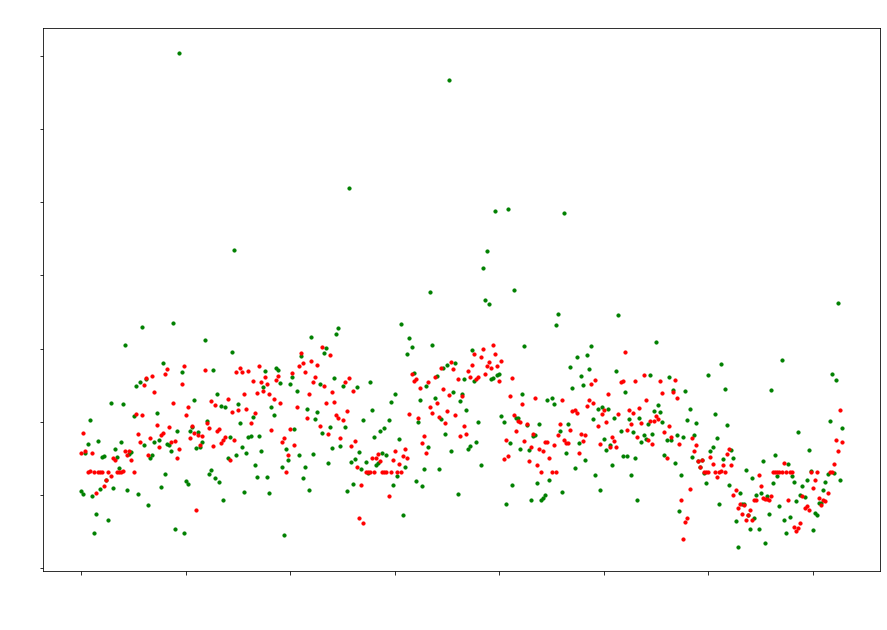

In [49]:
results=model2.predict(x_val)

plt.figure(figsize=(15, 10))
plt.scatter(range(len(y_val)),y_val,c='g', s=10)
plt.scatter(range(len(results)),results,c='r', s=10)
plt.title('validate', color='white', fontsize=20)
plt.xlabel('Num', color='white', fontsize=15)
plt.ylabel('', color='white', fontsize=15)
plt.xticks(rotation=45, color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)
plt.show()

In [50]:
accuracy = model2.evaluate(x_val, y_val)
print('Precisión en el conjunto de prueba:', accuracy)

365/365 [==============================] - 0s 30us/step
Precisión en el conjunto de prueba: [0.1269017262818062, 0.030824225395917892]


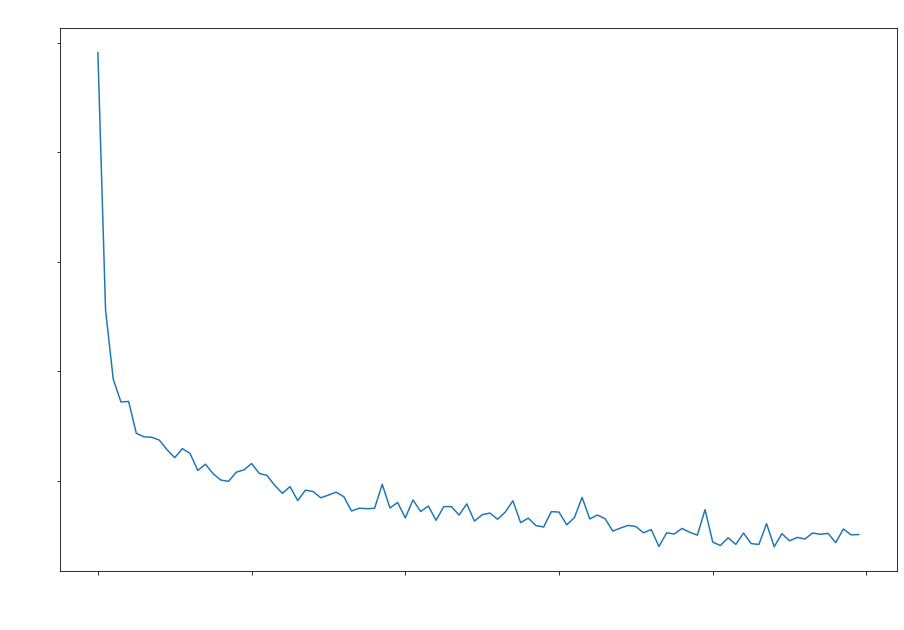

In [51]:
plt.figure(figsize=(15, 10))
plt.plot(history2.history['loss'])
plt.title('loss', color='white', fontsize=20)
plt.xlabel('EPOCHS', color='white', fontsize=15)
plt.ylabel('%', color='white', fontsize=15)
plt.xticks(rotation=45, color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)
plt.show()

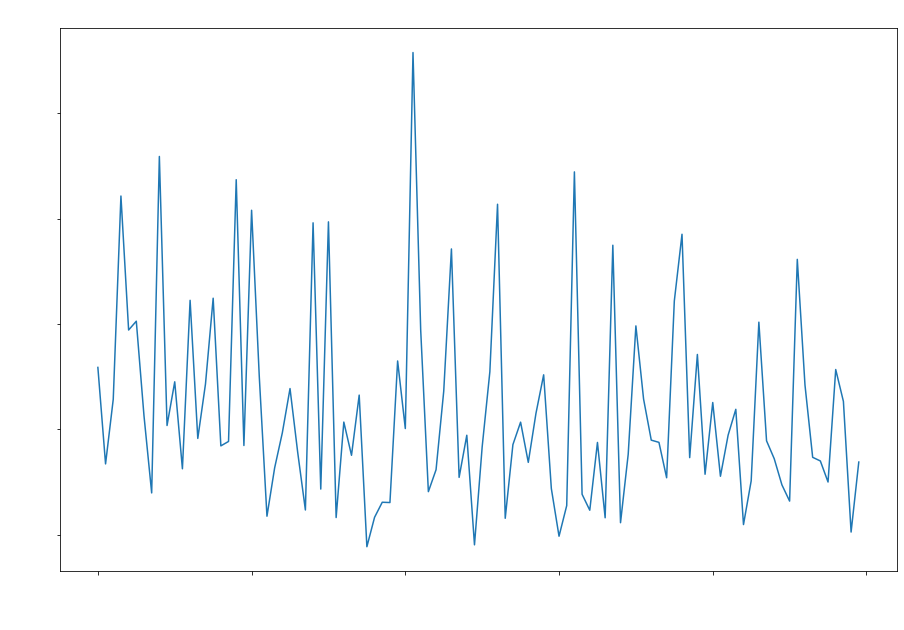

In [52]:
plt.figure(figsize=(15, 10))
plt.plot(history2.history['val_loss'])
plt.title('validate loss', color='white', fontsize=20)
plt.xlabel('EPOCHS', color='white', fontsize=15)
plt.ylabel('%', color='white', fontsize=15)
plt.xticks(rotation=45, color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)
plt.show()


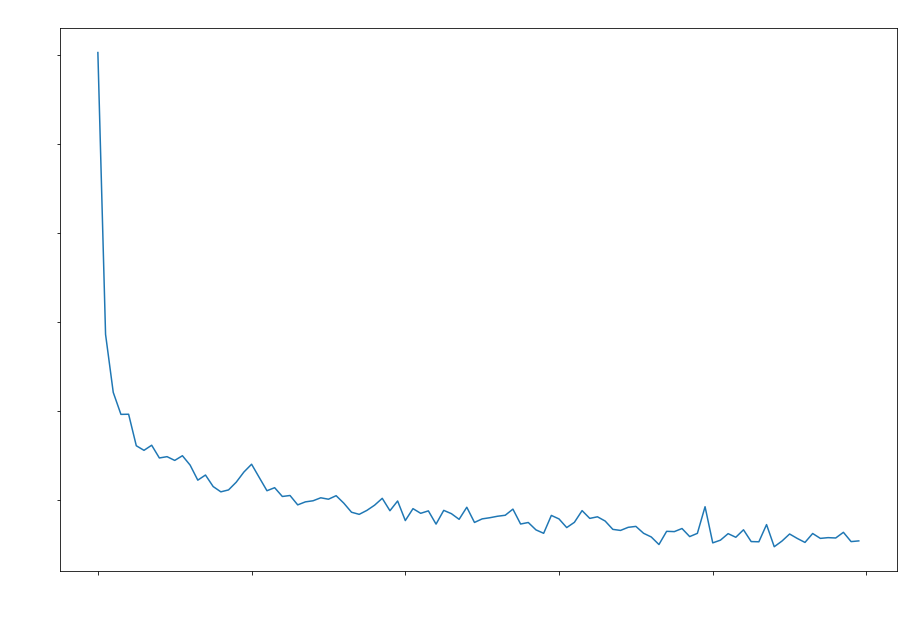

In [53]:
plt.figure(figsize=(15, 10))
plt.title('MSE', color='white', fontsize=20)
plt.plot(history2.history['mse'])
plt.xlabel('EPOCHS', color='white', fontsize=15)
plt.ylabel('%', color='white', fontsize=15)
plt.xticks(rotation=45, color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)
plt.show()


In [54]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.round()

,real,prediccion,diferencia
0,1917.0,2627.0,-710.0
1,1860.0,2987.0,-1127.0
2,2624.0,2650.0,-26.0
3,2781.0,2266.0,515.0
4,3240.0,2291.0,949.0
...,...,...,...
360,2244.0,2409.0,-165.0
361,3979.0,2862.0,1116.0
362,5418.0,2659.0,2758.0
363,2116.0,3413.0,-1296.0


In [55]:
compara2.describe().round()

,real,prediccion,diferencia
count,365.0,365.0,365.0
mean,3054.0,2965.0,89.0
std,1204.0,804.0,1192.0
min,876.0,1020.0,-3108.0
25%,2231.0,2272.0,-710.0
50%,2864.0,2908.0,39.0
75%,3718.0,3596.0,637.0
max,10067.0,4635.0,7380.0


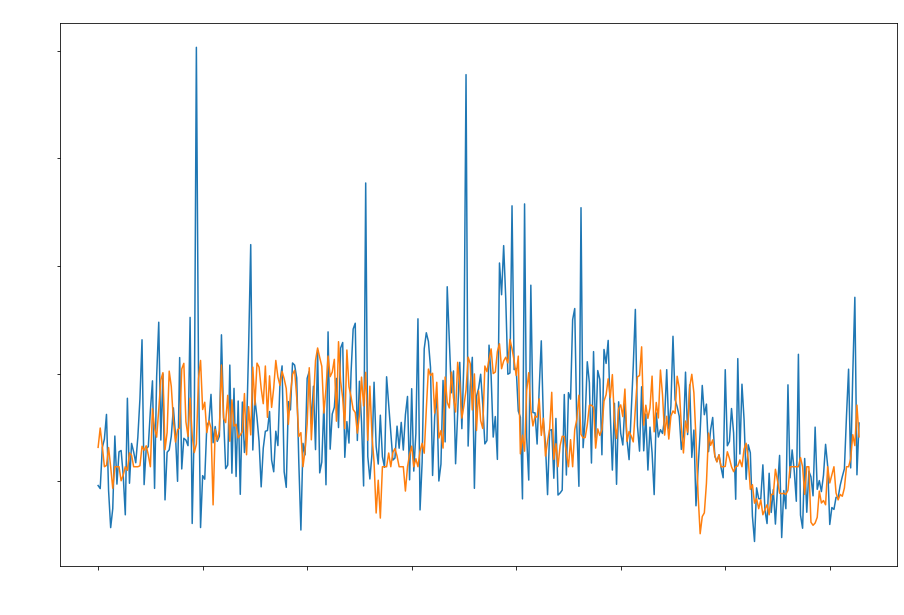

In [56]:
plt.figure(figsize=(15, 10))
compara2['real'].plot() #azul
compara2['prediccion'].plot() #rojo

plt.title('Predicciones Vs Real', color='white')
plt.xlabel('Mes', color='white')
plt.ylabel('Ventas', color='white')
plt.xticks(rotation=45, color='white')
plt.yticks(color='white')
plt.show()

## Nueva Prediccion

In [57]:
def agregarNuevoValor(x_val, nuevoValor, longitud_objetivo=365):
    # Asegurarse de que x_val tenga al menos la longitud requerida
    if x_val.shape[1] < longitud_objetivo:
        # Si x_val es más corto, rellenarlo con ceros
        relleno = np.zeros((x_val.shape[0], longitud_objetivo - x_val.shape[1], x_val.shape[2]))
        x_val = np.concatenate((x_val, relleno), axis=1)

    # Desplazar los valores hacia la izquierda
    x_val[0, :-1] = x_val[0, 1:]

    # Agregar el nuevo valor al final
    x_val[0, -1] = nuevoValor

    return x_val


In [58]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)

[array([-0.6846186], dtype=float32), array([-0.6317121], dtype=float32), array([-0.6811463], dtype=float32), array([-0.7376454], dtype=float32), array([-0.7340025], dtype=float32), array([-0.6852535], dtype=float32), array([-0.7376454], dtype=float32), array([-0.7965106], dtype=float32), array([-0.7376454], dtype=float32), array([-0.7376454], dtype=float32), array([-0.7376454], dtype=float32), array([-0.7760209], dtype=float32), array([-0.7605741], dtype=float32), array([-0.7376454], dtype=float32), array([-0.74745166], dtype=float32), array([-0.6998404], dtype=float32), array([-0.70614386], dtype=float32), array([-0.7376454], dtype=float32), array([-0.7376454], dtype=float32), array([-0.7376454], dtype=float32), array([-0.73506105], dtype=float32), array([-0.68165636], dtype=float32), array([-0.6924517], dtype=float32), array([-0.68033725], dtype=float32), array([-0.70507777], dtype=float32), array([-0.7376454], dtype=float32), array([-0.5789616], dtype=float32), array([-0.6325637], d

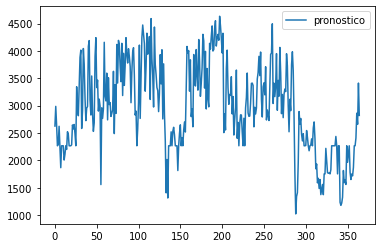

In [59]:
prediccion2006 = pd.DataFrame(inverted)
prediccion2006.columns = ['pronostico']
prediccion2006.plot()
prediccion2006.to_csv('pronostico_multivariate.csv')

# Modelo por Embeddings

In [60]:
df_modelo = df.drop(['PRODUCT_LINE', 'PRODUCT_CODE', 'CUSTOMER_NAME', 'day', 'ORDER_NUMBER', 'ORDER_LINE_NUMBER' ], axis=1)

In [61]:
df_modelo

,QUANTITY_ORDERED,PRICE_EACH,SALES,QTR_ID,MONTH_ID,YEAR_ID,day_of_week,num_category,num_customer,num_PC
ORDER_DATE,,,,,,,,,,
2003-02-24,30,95.70,2871.00,1,2,2003,0,4,10,4
2003-05-07,34,81.35,2765.90,2,5,2003,2,4,77,4
2003-07-01,41,94.74,3884.34,3,7,2003,1,4,4,4
2003-08-25,45,83.26,3746.70,3,8,2003,0,4,59,4
2003-10-10,49,100.00,5205.27,4,10,2003,4,4,81,4
...,...,...,...,...,...,...,...,...,...,...
2004-12-02,20,100.00,2244.40,4,12,2004,3,2,63,36
2005-01-31,29,100.00,3978.51,1,1,2005,0,2,67,36
2005-03-01,43,100.00,5417.57,1,3,2005,1,2,63,36


In [62]:
df_modelo.num_customer.max()

91

In [63]:
df_modelo.num_PC.max()

108

In [64]:
df_modelo.num_category.max()

6

In [65]:
PASOS=12
X = df['SALES']

# load dataset
values = X.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)
df_modelo = df_modelo.reset_index(drop=True)

contador=0
reframed['weekday']=df_modelo['day_of_week']
reframed['month']=df_modelo['MONTH_ID']
reframed['year']=df_modelo['YEAR_ID']
reframed['category']=df_modelo['num_category']
reframed['product']=df_modelo['num_PC']
reframed['customer']=df_modelo['num_customer']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=df_modelo['day_of_week'][i+8]
    reframed['month'].loc[contador]=df_modelo['MONTH_ID'][i+8]
    reframed['year'].loc[contador]=df_modelo['YEAR_ID'][i+8]
    reframed['category'].loc[contador]=df_modelo['num_category'][i+8]
    reframed['product'].loc[contador]=df_modelo['num_PC'][i+8]
    reframed['customer'].loc[contador]=df_modelo['num_customer'][i+8]
    contador=contador+1
reframed.head()

(2823, 13)


C:\Users\alesi\.conda\envs\tensorf\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),weekday,month,year,category,product,customer
0,-0.648713,-0.664168,-0.499700,-0.519940,-0.305455,-0.559194,-0.703597,-0.260303,-0.752011,-0.378514,-0.487741,-0.727809,-0.602003,0,12,2003,4,4,0
1,-0.664168,-0.499700,-0.519940,-0.305455,-0.559194,-0.703597,-0.260303,-0.752011,-0.378514,-0.487741,-0.727809,-0.602003,-0.530225,3,1,2004,4,4,48
2,-0.499700,-0.519940,-0.305455,-0.559194,-0.703597,-0.260303,-0.752011,-0.378514,-0.487741,-0.727809,-0.602003,-0.530225,-0.456612,4,2,2004,4,4,44
3,-0.519940,-0.305455,-0.559194,-0.703597,-0.260303,-0.752011,-0.378514,-0.487741,-0.727809,-0.602003,-0.530225,-0.456612,-0.468033,0,4,2004,4,4,79
4,-0.305455,-0.559194,-0.703597,-0.260303,-0.752011,-0.378514,-0.487741,-0.727809,-0.602003,-0.530225,-0.456612,-0.468033,-0.688948,1,5,2004,4,4,76


In [66]:
reordenado=reframed[ ['category','product','customer','weekday','month','year','var1(t-12)','var1(t-11)', 
                      'var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 
                      'var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)','var1(t)'] ]
reordenado.dropna(inplace=True)
reordenado

,category,product,customer,weekday,month,year,var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,4,4,0,0,12,2003,-0.648713,-0.664168,-0.499700,-0.519940,-0.305455,-0.559194,-0.703597,-0.260303,-0.752011,-0.378514,-0.487741,-0.727809,-0.602003
1,4,4,48,3,1,2004,-0.664168,-0.499700,-0.519940,-0.305455,-0.559194,-0.703597,-0.260303,-0.752011,-0.378514,-0.487741,-0.727809,-0.602003,-0.530225
2,4,4,44,4,2,2004,-0.499700,-0.519940,-0.305455,-0.559194,-0.703597,-0.260303,-0.752011,-0.378514,-0.487741,-0.727809,-0.602003,-0.530225,-0.456612
3,4,4,79,0,4,2004,-0.519940,-0.305455,-0.559194,-0.703597,-0.260303,-0.752011,-0.378514,-0.487741,-0.727809,-0.602003,-0.530225,-0.456612,-0.468033
4,4,4,76,1,5,2004,-0.305455,-0.559194,-0.703597,-0.260303,-0.752011,-0.378514,-0.487741,-0.727809,-0.602003,-0.530225,-0.456612,-0.468033,-0.688948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2806,2,36,24,3,10,2004,-0.676364,-0.735585,-0.895530,-0.849297,-0.854347,-0.821378,-0.821857,-0.788277,-0.764612,-0.743326,-0.598954,-0.470822,-0.740855
2807,2,36,41,4,10,2004,-0.735585,-0.895530,-0.849297,-0.854347,-0.821378,-0.821857,-0.788277,-0.764612,-0.743326,-0.598954,-0.470822,-0.740855,-0.485852
2808,2,36,45,2,11,2004,-0.895530,-0.849297,-0.854347,-0.821378,-0.821857,-0.788277,-0.764612,-0.743326,-0.598954,-0.470822,-0.740855,-0.485852,-0.274236
2809,2,36,30,6,11,2004,-0.849297,-0.854347,-0.821378,-0.821857,-0.788277,-0.764612,-0.743326,-0.598954,-0.470822,-0.740855,-0.485852,-0.274236,-0.759713


In [67]:
training_data = reordenado.drop('var1(t)',axis=1)#.values
target_data=reordenado['var1(t)']
#training_data.head()
valid_data = training_data[2811 -365:2811 ]
valid_target=target_data[2811 -365:2811 ]

training_data = training_data[0:2811 ]
target_data=target_data[0:2811 ]
print(training_data.shape,target_data.shape,valid_data.shape,valid_target.shape)
#training_data.head()

(2811, 18) (2811,) (365, 18) (365,)


In [68]:
from tensorflow.keras.layers import Input, Embedding, concatenate, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def crear_modeloEmbeddings(PASOS):
    # Tamaños de embeddings
    emb_dias = 256
    emb_meses = 512
    emb_year = 1024
    emb_category = 64  # Nuevo embedding para category
    emb_product = 64  # Nuevo embedding para product
    emb_customer = 64  # Nuevo embedding para customer

    # Entradas
    in_dias = Input(shape=[1], name='dias')
    in_meses = Input(shape=[1], name='meses')
    in_year = Input(shape=[1], name='years')
    in_category = Input(shape=[1], name='category')  # Nueva entrada
    in_product = Input(shape=[1], name='product')    # Nueva entrada
    in_customer = Input(shape=[1], name='customer')  # Nueva entrada
    in_cli = Input(shape=[PASOS], name='cli')

    # Embeddings
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    emb_meses = Embedding(12+1, emb_meses)(in_meses)
    emb_year = Embedding(2005+1, emb_year)(in_year)
    emb_category = Embedding(df_modelo.num_category.max()+1, emb_category)(in_category)
    emb_product = Embedding(df_modelo.num_PC.max()+1, emb_product)(in_product)
    emb_customer = Embedding(df_modelo.num_customer.max()+1, emb_customer)(in_customer)

    # Concatenación de embeddings
    fe = concatenate([emb_dias, emb_meses, emb_year, emb_category, emb_product, emb_customer])

    # Capas densas
    x = Flatten()(fe)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(PASOS, activation='relu')(x)
    outp = Dense(1, activation='linear')(x)

    # Creación y compilación del modelo
    model = Model(inputs=[in_dias, in_meses, in_year, in_category, in_product, in_customer, in_cli], outputs=outp)
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['MSE'])
    model.summary()

    return model


In [69]:
EPOCHS = 1000

# Crear el modelo
model = crear_modeloEmbeddings(PASOS)

# Datos continuos (como antes)
continuas = training_data[['var1(t-12)', 'var1(t-11)', 'var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)']]
valid_continuas = valid_data[['var1(t-12)', 'var1(t-11)', 'var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)']]

# Entrenar el modelo
history = model.fit(
    [
        training_data['weekday'], 
        training_data['month'], 
        training_data['year'], 
        training_data['category'],   # Nueva entrada
        training_data['product'],    # Nueva entrada
        training_data['customer'],   # Nueva entrada
        continuas
    ], 
    target_data, 
    epochs=EPOCHS,
    validation_data=(
        [
            valid_data['weekday'], 
            valid_data['month'], 
            valid_data['year'], 
            valid_data['category'],   # Nueva entrada
            valid_data['product'],    # Nueva entrada
            valid_data['customer'],   # Nueva entrada
            valid_continuas
        ], 
        valid_target
    )
)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dias (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
meses (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
years (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
category (InputLayer)           [(None, 1)]          0                                            
______________________________________________________________________________________________

2811/2811 [==============================] - 1s 331us/sample - loss: 0.1363 - MSE: 0.0371 - val_loss: 0.1028 - val_MSE: 0.0216
Epoch 26/1000
2811/2811 [==============================] - 1s 335us/sample - loss: 0.1354 - MSE: 0.0370 - val_loss: 0.1010 - val_MSE: 0.0213
Epoch 27/1000
2811/2811 [==============================] - 1s 339us/sample - loss: 0.1341 - MSE: 0.0369 - val_loss: 0.1032 - val_MSE: 0.0221
Epoch 28/1000
2811/2811 [==============================] - 1s 344us/sample - loss: 0.1341 - MSE: 0.0369 - val_loss: 0.0995 - val_MSE: 0.0213
Epoch 29/1000
2811/2811 [==============================] - 1s 344us/sample - loss: 0.1325 - MSE: 0.0365 - val_loss: 0.0983 - val_MSE: 0.0216
Epoch 30/1000
2811/2811 [==============================] - 1s 344us/sample - loss: 0.1330 - MSE: 0.0361 - val_loss: 0.0960 - val_MSE: 0.0206
Epoch 31/1000
2811/2811 [==============================] - 1s 338us/sample - loss: 0.1302 - MSE: 0.0356 - val_loss: 0.0966 - val_MSE: 0.0213
Epoch 32/1000
2811/2811 [==

2811/2811 [==============================] - 1s 358us/sample - loss: 0.0943 - MSE: 0.0201 - val_loss: 0.0675 - val_MSE: 0.0095
Epoch 84/1000
2811/2811 [==============================] - 1s 363us/sample - loss: 0.0941 - MSE: 0.0200 - val_loss: 0.0654 - val_MSE: 0.0096
Epoch 85/1000
2811/2811 [==============================] - 1s 360us/sample - loss: 0.0947 - MSE: 0.0198 - val_loss: 0.0645 - val_MSE: 0.0097
Epoch 86/1000
2811/2811 [==============================] - 1s 370us/sample - loss: 0.0925 - MSE: 0.0192 - val_loss: 0.0642 - val_MSE: 0.0090
Epoch 87/1000
2811/2811 [==============================] - 1s 374us/sample - loss: 0.0937 - MSE: 0.0197 - val_loss: 0.0628 - val_MSE: 0.0091
Epoch 88/1000
2811/2811 [==============================] - 1s 353us/sample - loss: 0.0923 - MSE: 0.0194 - val_loss: 0.0625 - val_MSE: 0.0088
Epoch 89/1000
2811/2811 [==============================] - 1s 347us/sample - loss: 0.0916 - MSE: 0.0189 - val_loss: 0.0651 - val_MSE: 0.0099
Epoch 90/1000
2811/2811 [==

Epoch 141/1000
2811/2811 [==============================] - 1s 343us/sample - loss: 0.0789 - MSE: 0.0145 - val_loss: 0.0521 - val_MSE: 0.0059
Epoch 142/1000
2811/2811 [==============================] - 1s 328us/sample - loss: 0.0793 - MSE: 0.0147 - val_loss: 0.0503 - val_MSE: 0.0059
Epoch 143/1000
2811/2811 [==============================] - 1s 326us/sample - loss: 0.0806 - MSE: 0.0153 - val_loss: 0.0492 - val_MSE: 0.0053
Epoch 144/1000
2811/2811 [==============================] - 1s 326us/sample - loss: 0.0782 - MSE: 0.0143 - val_loss: 0.0487 - val_MSE: 0.0051
Epoch 145/1000
2811/2811 [==============================] - 1s 327us/sample - loss: 0.0793 - MSE: 0.0149 - val_loss: 0.0503 - val_MSE: 0.0057
Epoch 146/1000
2811/2811 [==============================] - 1s 327us/sample - loss: 0.0776 - MSE: 0.0146 - val_loss: 0.0536 - val_MSE: 0.0066
Epoch 147/1000
2811/2811 [==============================] - 1s 329us/sample - loss: 0.0785 - MSE: 0.0147 - val_loss: 0.0548 - val_MSE: 0.0064
Epoch 

Epoch 199/1000
2811/2811 [==============================] - 1s 351us/sample - loss: 0.0714 - MSE: 0.0126 - val_loss: 0.0450 - val_MSE: 0.0045
Epoch 200/1000
2811/2811 [==============================] - 1s 442us/sample - loss: 0.0709 - MSE: 0.0120 - val_loss: 0.0466 - val_MSE: 0.0047
Epoch 201/1000
2811/2811 [==============================] - 1s 356us/sample - loss: 0.0714 - MSE: 0.0125 - val_loss: 0.0462 - val_MSE: 0.0048
Epoch 202/1000
2811/2811 [==============================] - 1s 352us/sample - loss: 0.0730 - MSE: 0.0133 - val_loss: 0.0446 - val_MSE: 0.0045
Epoch 203/1000
2811/2811 [==============================] - 1s 346us/sample - loss: 0.0722 - MSE: 0.0128 - val_loss: 0.0447 - val_MSE: 0.0044
Epoch 204/1000
2811/2811 [==============================] - 1s 345us/sample - loss: 0.0719 - MSE: 0.0122 - val_loss: 0.0458 - val_MSE: 0.0046
Epoch 205/1000
2811/2811 [==============================] - 1s 326us/sample - loss: 0.0713 - MSE: 0.0126 - val_loss: 0.0423 - val_MSE: 0.0042
Epoch 

Epoch 257/1000
2811/2811 [==============================] - 1s 346us/sample - loss: 0.0684 - MSE: 0.0112 - val_loss: 0.0442 - val_MSE: 0.0044
Epoch 258/1000
2811/2811 [==============================] - 1s 366us/sample - loss: 0.0686 - MSE: 0.0112 - val_loss: 0.0401 - val_MSE: 0.0038
Epoch 259/1000
2811/2811 [==============================] - 1s 354us/sample - loss: 0.0666 - MSE: 0.0108 - val_loss: 0.0398 - val_MSE: 0.0038
Epoch 260/1000
2811/2811 [==============================] - 1s 363us/sample - loss: 0.0669 - MSE: 0.0111 - val_loss: 0.0401 - val_MSE: 0.0038
Epoch 261/1000
2811/2811 [==============================] - 1s 348us/sample - loss: 0.0667 - MSE: 0.0113 - val_loss: 0.0410 - val_MSE: 0.0039
Epoch 262/1000
2811/2811 [==============================] - 1s 334us/sample - loss: 0.0671 - MSE: 0.0110 - val_loss: 0.0435 - val_MSE: 0.0041
Epoch 263/1000
2811/2811 [==============================] - 1s 321us/sample - loss: 0.0688 - MSE: 0.0114 - val_loss: 0.0427 - val_MSE: 0.0040
Epoch 

Epoch 315/1000
2811/2811 [==============================] - 1s 325us/sample - loss: 0.0638 - MSE: 0.0102 - val_loss: 0.0405 - val_MSE: 0.0041
Epoch 316/1000
2811/2811 [==============================] - 1s 325us/sample - loss: 0.0634 - MSE: 0.0101 - val_loss: 0.0410 - val_MSE: 0.0039
Epoch 317/1000
2811/2811 [==============================] - 1s 331us/sample - loss: 0.0668 - MSE: 0.0109 - val_loss: 0.0423 - val_MSE: 0.0042
Epoch 318/1000
2811/2811 [==============================] - 1s 344us/sample - loss: 0.0647 - MSE: 0.0107 - val_loss: 0.0394 - val_MSE: 0.0038
Epoch 319/1000
2811/2811 [==============================] - 1s 346us/sample - loss: 0.0645 - MSE: 0.0105 - val_loss: 0.0392 - val_MSE: 0.0038
Epoch 320/1000
2811/2811 [==============================] - 1s 344us/sample - loss: 0.0636 - MSE: 0.0099 - val_loss: 0.0453 - val_MSE: 0.0046
Epoch 321/1000
2811/2811 [==============================] - 1s 349us/sample - loss: 0.0639 - MSE: 0.0101 - val_loss: 0.0407 - val_MSE: 0.0041
Epoch 

Epoch 373/1000
2811/2811 [==============================] - 1s 346us/sample - loss: 0.0615 - MSE: 0.0094 - val_loss: 0.0390 - val_MSE: 0.0036
Epoch 374/1000
2811/2811 [==============================] - 1s 324us/sample - loss: 0.0633 - MSE: 0.0103 - val_loss: 0.0400 - val_MSE: 0.0041
Epoch 375/1000
2811/2811 [==============================] - 1s 323us/sample - loss: 0.0643 - MSE: 0.0104 - val_loss: 0.0415 - val_MSE: 0.0043
Epoch 376/1000
2811/2811 [==============================] - 1s 326us/sample - loss: 0.0619 - MSE: 0.0094 - val_loss: 0.0380 - val_MSE: 0.0036
Epoch 377/1000
2811/2811 [==============================] - 1s 332us/sample - loss: 0.0604 - MSE: 0.0094 - val_loss: 0.0382 - val_MSE: 0.0038
Epoch 378/1000
2811/2811 [==============================] - 1s 343us/sample - loss: 0.0651 - MSE: 0.0111 - val_loss: 0.0392 - val_MSE: 0.0040
Epoch 379/1000
2811/2811 [==============================] - 1s 334us/sample - loss: 0.0621 - MSE: 0.0096 - val_loss: 0.0372 - val_MSE: 0.0035
Epoch 

Epoch 431/1000
2811/2811 [==============================] - 1s 383us/sample - loss: 0.0620 - MSE: 0.0093 - val_loss: 0.0390 - val_MSE: 0.0034
Epoch 432/1000
2811/2811 [==============================] - 1s 355us/sample - loss: 0.0575 - MSE: 0.0086 - val_loss: 0.0381 - val_MSE: 0.0037
Epoch 433/1000
2811/2811 [==============================] - 1s 390us/sample - loss: 0.0589 - MSE: 0.0085 - val_loss: 0.0377 - val_MSE: 0.0036
Epoch 434/1000
2811/2811 [==============================] - 1s 367us/sample - loss: 0.0607 - MSE: 0.0092 - val_loss: 0.0352 - val_MSE: 0.0033
Epoch 435/1000
2811/2811 [==============================] - 1s 341us/sample - loss: 0.0607 - MSE: 0.0091 - val_loss: 0.0376 - val_MSE: 0.0036
Epoch 436/1000
2811/2811 [==============================] - 1s 348us/sample - loss: 0.0602 - MSE: 0.0096 - val_loss: 0.0372 - val_MSE: 0.0034
Epoch 437/1000
2811/2811 [==============================] - 1s 328us/sample - loss: 0.0600 - MSE: 0.0092 - val_loss: 0.0388 - val_MSE: 0.0038
Epoch 

Epoch 489/1000
2811/2811 [==============================] - 1s 334us/sample - loss: 0.0563 - MSE: 0.0080 - val_loss: 0.0359 - val_MSE: 0.0033
Epoch 490/1000
2811/2811 [==============================] - 1s 327us/sample - loss: 0.0572 - MSE: 0.0083 - val_loss: 0.0387 - val_MSE: 0.0035
Epoch 491/1000
2811/2811 [==============================] - 1s 327us/sample - loss: 0.0576 - MSE: 0.0083 - val_loss: 0.0380 - val_MSE: 0.0035
Epoch 492/1000
2811/2811 [==============================] - 1s 353us/sample - loss: 0.0595 - MSE: 0.0101 - val_loss: 0.0367 - val_MSE: 0.0033
Epoch 493/1000
2811/2811 [==============================] - 1s 345us/sample - loss: 0.0570 - MSE: 0.0082 - val_loss: 0.0372 - val_MSE: 0.0035
Epoch 494/1000
2811/2811 [==============================] - 1s 353us/sample - loss: 0.0569 - MSE: 0.0085 - val_loss: 0.0355 - val_MSE: 0.0033
Epoch 495/1000
2811/2811 [==============================] - 1s 341us/sample - loss: 0.0586 - MSE: 0.0087 - val_loss: 0.0369 - val_MSE: 0.0035
Epoch 

Epoch 547/1000
2811/2811 [==============================] - 1s 330us/sample - loss: 0.0570 - MSE: 0.0083 - val_loss: 0.0360 - val_MSE: 0.0033
Epoch 548/1000
2811/2811 [==============================] - 1s 329us/sample - loss: 0.0560 - MSE: 0.0078 - val_loss: 0.0357 - val_MSE: 0.0033
Epoch 549/1000
2811/2811 [==============================] - 1s 327us/sample - loss: 0.0551 - MSE: 0.0084 - val_loss: 0.0349 - val_MSE: 0.0032
Epoch 550/1000
2811/2811 [==============================] - 1s 331us/sample - loss: 0.0567 - MSE: 0.0080 - val_loss: 0.0353 - val_MSE: 0.0032
Epoch 551/1000
2811/2811 [==============================] - 1s 328us/sample - loss: 0.0577 - MSE: 0.0083 - val_loss: 0.0361 - val_MSE: 0.0033
Epoch 552/1000
2811/2811 [==============================] - 1s 326us/sample - loss: 0.0569 - MSE: 0.0086 - val_loss: 0.0354 - val_MSE: 0.0033
Epoch 553/1000
2811/2811 [==============================] - 1s 325us/sample - loss: 0.0573 - MSE: 0.0084 - val_loss: 0.0348 - val_MSE: 0.0032
Epoch 

Epoch 605/1000
2811/2811 [==============================] - 1s 328us/sample - loss: 0.0584 - MSE: 0.0091 - val_loss: 0.0319 - val_MSE: 0.0027
Epoch 606/1000
2811/2811 [==============================] - 1s 327us/sample - loss: 0.0555 - MSE: 0.0087 - val_loss: 0.0323 - val_MSE: 0.0029
Epoch 607/1000
2811/2811 [==============================] - 1s 338us/sample - loss: 0.0549 - MSE: 0.0076 - val_loss: 0.0328 - val_MSE: 0.0029
Epoch 608/1000
2811/2811 [==============================] - 1s 347us/sample - loss: 0.0561 - MSE: 0.0085 - val_loss: 0.0350 - val_MSE: 0.0032
Epoch 609/1000
2811/2811 [==============================] - 1s 345us/sample - loss: 0.0571 - MSE: 0.0086 - val_loss: 0.0342 - val_MSE: 0.0031
Epoch 610/1000
2811/2811 [==============================] - 1s 343us/sample - loss: 0.0550 - MSE: 0.0079 - val_loss: 0.0334 - val_MSE: 0.0029
Epoch 611/1000
2811/2811 [==============================] - 1s 344us/sample - loss: 0.0564 - MSE: 0.0089 - val_loss: 0.0357 - val_MSE: 0.0032
Epoch 

Epoch 663/1000
2811/2811 [==============================] - 1s 369us/sample - loss: 0.0547 - MSE: 0.0082 - val_loss: 0.0358 - val_MSE: 0.0034
Epoch 664/1000
2811/2811 [==============================] - 1s 361us/sample - loss: 0.0554 - MSE: 0.0078 - val_loss: 0.0344 - val_MSE: 0.0031
Epoch 665/1000
2811/2811 [==============================] - 1s 327us/sample - loss: 0.0533 - MSE: 0.0071 - val_loss: 0.0345 - val_MSE: 0.0032
Epoch 666/1000
2811/2811 [==============================] - 1s 336us/sample - loss: 0.0548 - MSE: 0.0078 - val_loss: 0.0353 - val_MSE: 0.0031
Epoch 667/1000
2811/2811 [==============================] - 1s 324us/sample - loss: 0.0542 - MSE: 0.0079 - val_loss: 0.0391 - val_MSE: 0.0035
Epoch 668/1000
2811/2811 [==============================] - 1s 337us/sample - loss: 0.0557 - MSE: 0.0082 - val_loss: 0.0371 - val_MSE: 0.0033
Epoch 669/1000
2811/2811 [==============================] - 1s 325us/sample - loss: 0.0571 - MSE: 0.0089 - val_loss: 0.0347 - val_MSE: 0.0031
Epoch 

Epoch 721/1000
2811/2811 [==============================] - 1s 329us/sample - loss: 0.0532 - MSE: 0.0075 - val_loss: 0.0352 - val_MSE: 0.0031
Epoch 722/1000
2811/2811 [==============================] - 1s 331us/sample - loss: 0.0542 - MSE: 0.0081 - val_loss: 0.0325 - val_MSE: 0.0027
Epoch 723/1000
2811/2811 [==============================] - 1s 337us/sample - loss: 0.0533 - MSE: 0.0075 - val_loss: 0.0350 - val_MSE: 0.0032
Epoch 724/1000
2811/2811 [==============================] - 1s 351us/sample - loss: 0.0555 - MSE: 0.0087 - val_loss: 0.0347 - val_MSE: 0.0032
Epoch 725/1000
2811/2811 [==============================] - 1s 352us/sample - loss: 0.0530 - MSE: 0.0080 - val_loss: 0.0335 - val_MSE: 0.0029
Epoch 726/1000
2811/2811 [==============================] - 1s 379us/sample - loss: 0.0551 - MSE: 0.0089 - val_loss: 0.0366 - val_MSE: 0.0032
Epoch 727/1000
2811/2811 [==============================] - 1s 385us/sample - loss: 0.0540 - MSE: 0.0081 - val_loss: 0.0367 - val_MSE: 0.0032
Epoch 

Epoch 779/1000
2811/2811 [==============================] - 1s 344us/sample - loss: 0.0534 - MSE: 0.0078 - val_loss: 0.0345 - val_MSE: 0.0030
Epoch 780/1000
2811/2811 [==============================] - 1s 327us/sample - loss: 0.0526 - MSE: 0.0077 - val_loss: 0.0346 - val_MSE: 0.0030
Epoch 781/1000
2811/2811 [==============================] - 1s 329us/sample - loss: 0.0530 - MSE: 0.0078 - val_loss: 0.0347 - val_MSE: 0.0030
Epoch 782/1000
2811/2811 [==============================] - 1s 324us/sample - loss: 0.0527 - MSE: 0.0076 - val_loss: 0.0337 - val_MSE: 0.0031
Epoch 783/1000
2811/2811 [==============================] - 1s 350us/sample - loss: 0.0552 - MSE: 0.0083 - val_loss: 0.0353 - val_MSE: 0.0033
Epoch 784/1000
2811/2811 [==============================] - 1s 346us/sample - loss: 0.0543 - MSE: 0.0079 - val_loss: 0.0330 - val_MSE: 0.0033
Epoch 785/1000
2811/2811 [==============================] - 1s 336us/sample - loss: 0.0536 - MSE: 0.0073 - val_loss: 0.0331 - val_MSE: 0.0030
Epoch 

Epoch 837/1000
2811/2811 [==============================] - 1s 344us/sample - loss: 0.0542 - MSE: 0.0079 - val_loss: 0.0337 - val_MSE: 0.0031
Epoch 838/1000
2811/2811 [==============================] - 1s 339us/sample - loss: 0.0517 - MSE: 0.0072 - val_loss: 0.0358 - val_MSE: 0.0035
Epoch 839/1000
2811/2811 [==============================] - 1s 355us/sample - loss: 0.0534 - MSE: 0.0080 - val_loss: 0.0326 - val_MSE: 0.0028
Epoch 840/1000
2811/2811 [==============================] - 1s 382us/sample - loss: 0.0549 - MSE: 0.0081 - val_loss: 0.0330 - val_MSE: 0.0029
Epoch 841/1000
2811/2811 [==============================] - 1s 369us/sample - loss: 0.0552 - MSE: 0.0082 - val_loss: 0.0353 - val_MSE: 0.0033
Epoch 842/1000
2811/2811 [==============================] - 1s 349us/sample - loss: 0.0520 - MSE: 0.0070 - val_loss: 0.0335 - val_MSE: 0.0030
Epoch 843/1000
2811/2811 [==============================] - 1s 375us/sample - loss: 0.0524 - MSE: 0.0075 - val_loss: 0.0331 - val_MSE: 0.0029
Epoch 

Epoch 895/1000
2811/2811 [==============================] - 1s 339us/sample - loss: 0.0525 - MSE: 0.0076 - val_loss: 0.0316 - val_MSE: 0.0027
Epoch 896/1000
2811/2811 [==============================] - 1s 327us/sample - loss: 0.0533 - MSE: 0.0083 - val_loss: 0.0337 - val_MSE: 0.0033
Epoch 897/1000
2811/2811 [==============================] - 1s 324us/sample - loss: 0.0538 - MSE: 0.0080 - val_loss: 0.0336 - val_MSE: 0.0034
Epoch 898/1000
2811/2811 [==============================] - 1s 328us/sample - loss: 0.0538 - MSE: 0.0084 - val_loss: 0.0342 - val_MSE: 0.0030
Epoch 899/1000
2811/2811 [==============================] - 1s 326us/sample - loss: 0.0513 - MSE: 0.0072 - val_loss: 0.0301 - val_MSE: 0.0026
Epoch 900/1000
2811/2811 [==============================] - 1s 333us/sample - loss: 0.0521 - MSE: 0.0077 - val_loss: 0.0323 - val_MSE: 0.0028
Epoch 901/1000
2811/2811 [==============================] - 1s 326us/sample - loss: 0.0513 - MSE: 0.0073 - val_loss: 0.0322 - val_MSE: 0.0028
Epoch 

Epoch 953/1000
2811/2811 [==============================] - 1s 347us/sample - loss: 0.0502 - MSE: 0.0069 - val_loss: 0.0315 - val_MSE: 0.0028
Epoch 954/1000
2811/2811 [==============================] - 1s 361us/sample - loss: 0.0513 - MSE: 0.0075 - val_loss: 0.0329 - val_MSE: 0.0029
Epoch 955/1000
2811/2811 [==============================] - 1s 403us/sample - loss: 0.0507 - MSE: 0.0072 - val_loss: 0.0335 - val_MSE: 0.0028
Epoch 956/1000
2811/2811 [==============================] - 1s 369us/sample - loss: 0.0529 - MSE: 0.0080 - val_loss: 0.0334 - val_MSE: 0.0029
Epoch 957/1000
2811/2811 [==============================] - 1s 363us/sample - loss: 0.0521 - MSE: 0.0073 - val_loss: 0.0327 - val_MSE: 0.0028
Epoch 958/1000
2811/2811 [==============================] - 1s 369us/sample - loss: 0.0524 - MSE: 0.0078 - val_loss: 0.0347 - val_MSE: 0.0031
Epoch 959/1000
2811/2811 [==============================] - 1s 371us/sample - loss: 0.0517 - MSE: 0.0075 - val_loss: 0.0317 - val_MSE: 0.0027
Epoch 

## Resultados

365


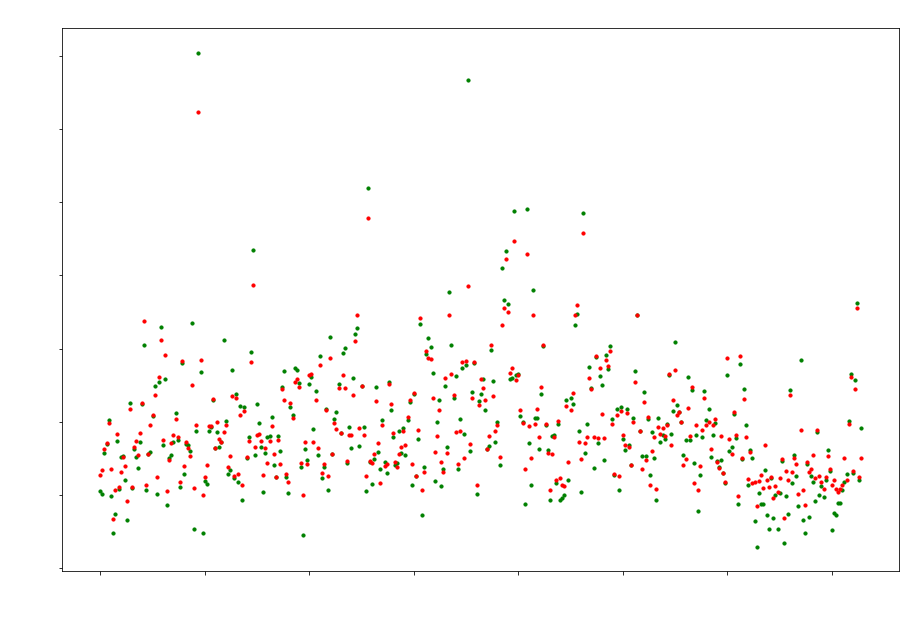

In [70]:
# Asegúrate de que 'valid_data' incluya la columna del año
results = model.predict(  [
            valid_data['weekday'], 
            valid_data['month'], 
            valid_data['year'], 
            valid_data['category'],   # Nueva entrada
            valid_data['product'],    # Nueva entrada
            valid_data['customer'],   # Nueva entrada
            valid_continuas
        ])
print(len(results))

plt.figure(figsize=(15, 10))
plt.scatter(range(len(y_val)), y_val, c='g', s=10)  # Asegúrate de que y_val esté definido correctamente
plt.scatter(range(len(results)), results, c='r', s=10)
plt.title('Validación', color='white', fontsize=20)
plt.xlabel('Número', color='white', fontsize=15)
plt.ylabel('Valor', color='white', fontsize=15)  # Puedes cambiar 'Valor' por lo que representa en tus datos
plt.xticks(rotation=45, color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)
plt.show()


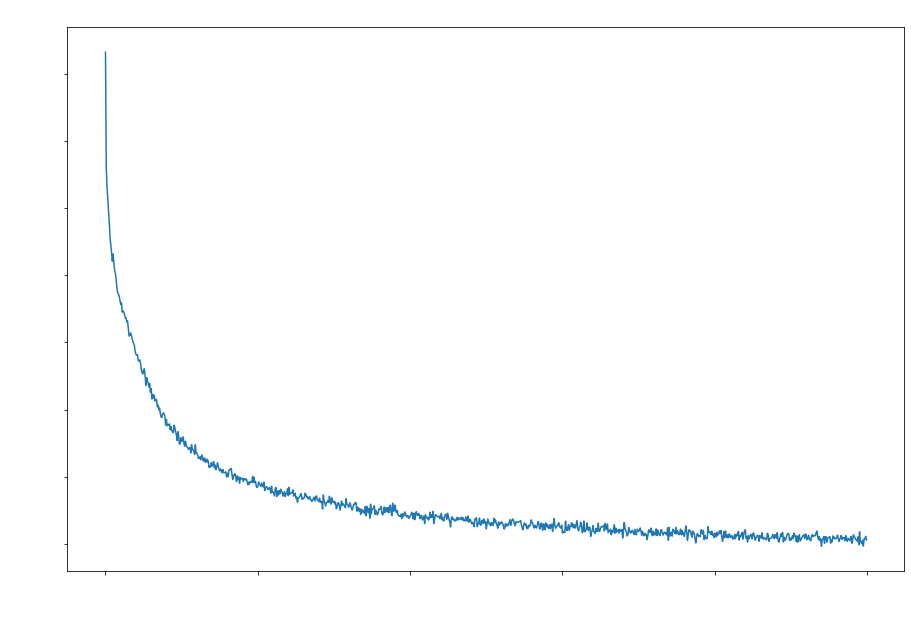

In [71]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'])
plt.title('loss', color='white', fontsize=20)
plt.xlabel('EPOCHS', color='white', fontsize=15)
plt.ylabel('%', color='white', fontsize=15)
plt.xticks(rotation=45, color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)
plt.show()

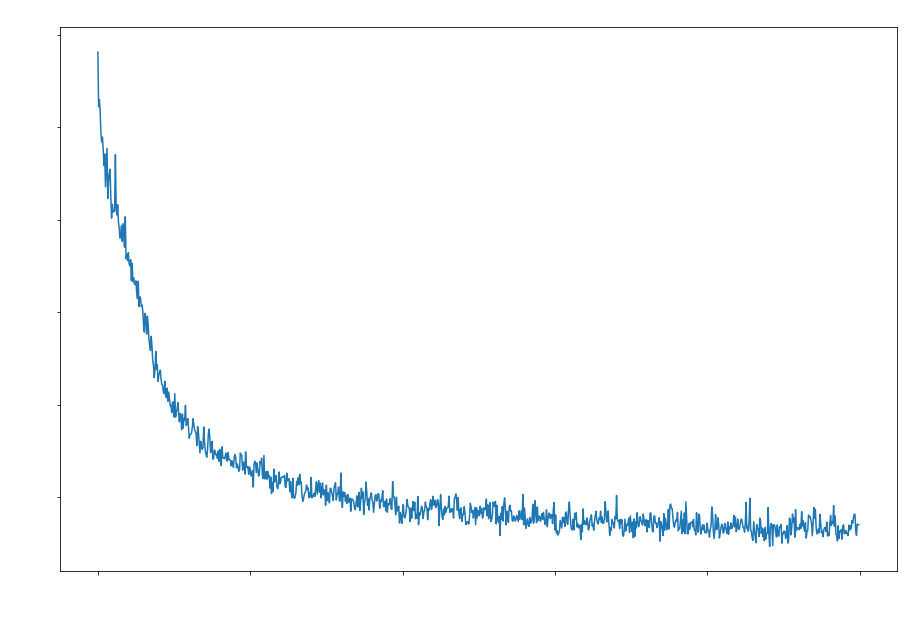

In [72]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['val_loss'])
plt.title('validate loss', color='white', fontsize=20)
plt.xlabel('EPOCHS', color='white', fontsize=15)
plt.ylabel('%', color='white', fontsize=15)
plt.xticks(rotation=45, color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)
plt.show()


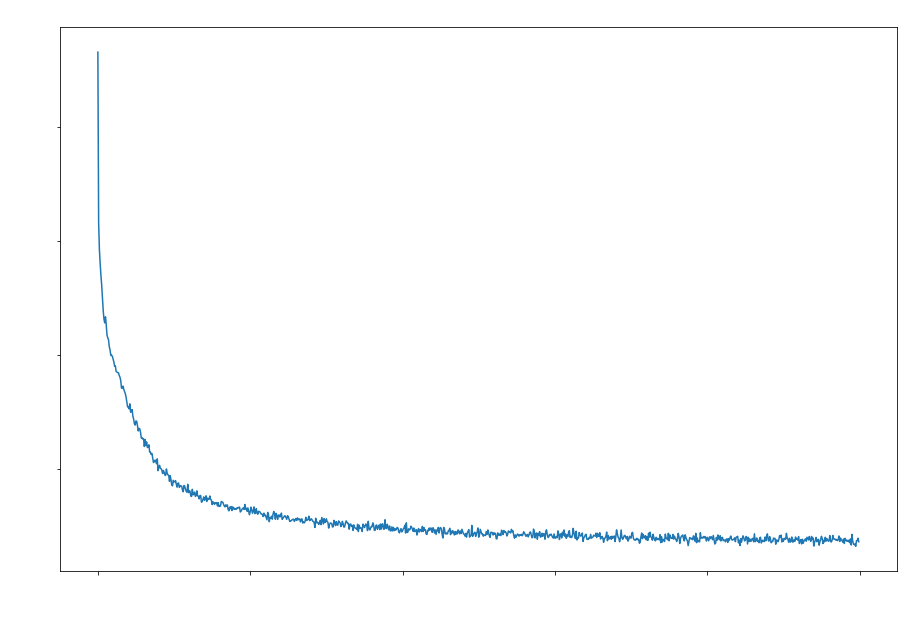

In [73]:
plt.figure(figsize=(15, 10))
plt.title('MSE', color='white', fontsize=20)
plt.plot(history.history['MSE'])
plt.xlabel('EPOCHS', color='white', fontsize=15)
plt.ylabel('%', color='white', fontsize=15)
plt.xticks(rotation=45, color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)
plt.show()


In [74]:
compara = pd.DataFrame(np.array([valid_target, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']

In [75]:
compara2.describe()

,real,prediccion,diferencia
count,365.000000,365.000000,365.000000
mean,3053.629150,3073.249023,-19.619804
std,1203.949707,987.291321,375.831268
min,875.910095,1398.725342,-854.766357
25%,2231.000000,2377.403320,-186.041748
50%,2864.319824,2919.509766,-34.650146
75%,3717.500244,3599.504883,104.625000
max,10066.599609,8957.221680,3828.945312


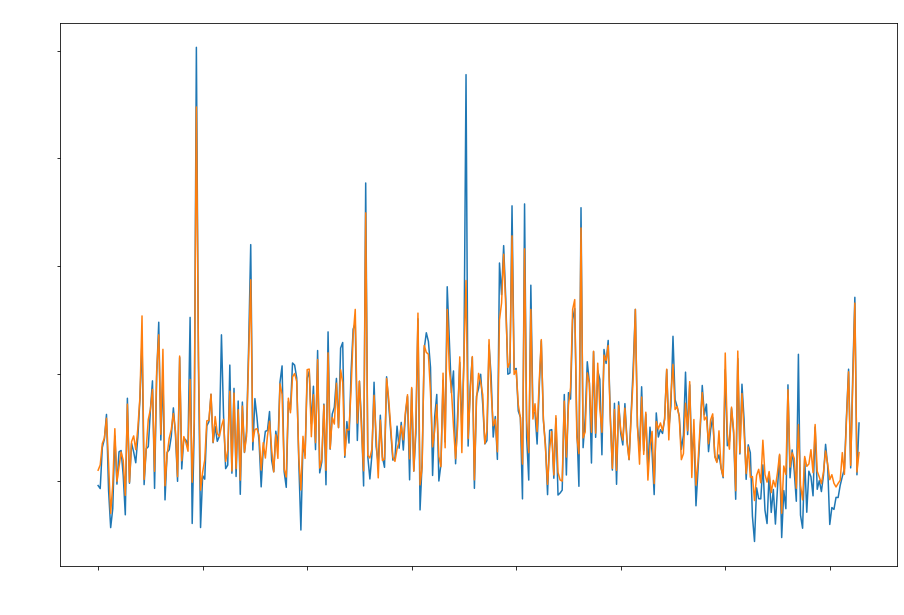

In [76]:
plt.figure(figsize=(15, 10))
compara2['real'].plot() #azul
compara2['prediccion'].plot() #rojo

plt.title('Predicciones Vs Real', color='white')
plt.xlabel('Dia', color='white')
plt.ylabel('Ventas', color='white')
plt.xticks(rotation=45, color='white')
plt.yticks(color='white')
plt.show()

## Nueva prediccion

In [77]:
def agregarNuevoValor(x_val, nuevoValor, longitud_objetivo=365):
    # Asegurarse de que x_val tenga al menos la longitud requerida
    if x_val.shape[1] < longitud_objetivo:
        # Si x_val es más corto, rellenarlo con ceros
        relleno = np.zeros((x_val.shape[0], longitud_objetivo - x_val.shape[1], x_val.shape[2]))
        x_val = np.concatenate((x_val, relleno), axis=1)

    # Desplazar los valores hacia la izquierda
    x_val[0, :-1] = x_val[0, 1:]

    # Agregar el nuevo valor al final
    x_val[0, -1] = nuevoValor

    return x_val

In [81]:
adimen = [x for x in results]    
adimen
inverted = scaler.inverse_transform(adimen)

In [82]:
prediccion = pd.DataFrame(inverted)
prediccion.round()

,0
0,2202.0
1,2299.0
2,2698.0
3,2798.0
4,3168.0
...,...
360,2292.0
361,3818.0
362,5310.0
363,2168.0


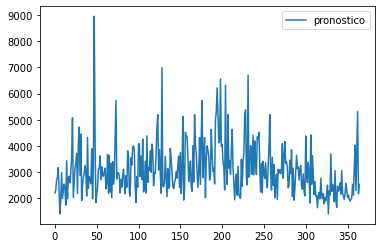

In [83]:
prediccion2006 = pd.DataFrame(inverted)
prediccion2006.columns = ['pronostico']
prediccion2006.plot()
prediccion2006.to_csv('pronostico_embeddings.csv')